# Datasets

### Cleaup & Loading

In [1]:
# Data Manipulation
import pandas as pd

# URL Library
import urllib.request
import zipfile

In [2]:
# Retrieving & storage
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [3]:
# Function Extration
def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file & read it into pandas
    DataFrame.
    
    Parameters:
        src '(str:)' URL of the zip file to be downloaded and extrated.
        dst 'str': Local file path where the zip file will be written.
        member_name: Name of the member file inside the zip file to be
            read into a DataFrame.
            
    Returns:
        pandas.DataFrame containing the contents of member file.
    """
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

In [4]:
raw = extract_zip(url, fname, member_name)

/var/folders/wh/l_q69dcj75z0c82jy8ry71f40000gn/T/ipykernel_63035/3680407660.py:22: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))


## CleanUp Pipeline 

In [5]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """    
    return (df_
            .assign(age=df_.Q2.str.slice(0,2).astype(int),
                    education=df_.Q4.replace({'Master’s degree': 18,
                         'Bachelor’s degree': 16,
                         'Doctoral degree': 20,
'Some college/university study without earning a bachelor’s degree': 13,
                         'Professional degree': 19,
                         'I prefer not to answer': None,
                         'No formal education past high school': 12}),
                    major=(df_.Q5
                              .pipe(topn, n=3)
                              .replace({
                        'Computer science (software engineering, etc.)': 'cs',
                        'Engineering (non-computer focused)': 'eng',
                        'Mathematics or statistics': 'stat'})
                         ),
                    years_exp=(df_.Q8.str.replace('+','', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
  .str.replace('I do not wish to disclose my approximate yearly compensation',
             '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)
                                    ),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                'python,r,sql'.split(',')]   
       )


In [6]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [7]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
class TweakKagTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, ycol=None):
        self.ycol = ycol
        
    def transform(self, X):
        return tweak_kag(X)
    
    def fit(self, X, y=None):
        return self

In [9]:
def get_rawX_y(df, y_col):
    raw = (df
           .query('Q3.isin(["United States of America", "China", "India"]) '
              'and Q6.isin(["Data Scientist", "Software Engineer"])')
    )
    return raw.drop(columns=[y_col]), raw[y_col]

In [10]:
# Create Pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
     ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True, variables=['Q1', 'Q3', 'major'])),
     ('num_impute', imputation.MeanMedianImputer(imputation_method='median', variables=['education', 'years_exp']))]
)

In [11]:
from sklearn import model_selection

In [12]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
    kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [13]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)

X_test = kag_pl.transform(kag_X_test)

In [14]:
print(X_train)

       age  education  years_exp  compensation  python  r  sql  Q1_Male  \
587     25       18.0        4.0             0       1  0    1        1   
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe  \
587            0             

In [15]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

## Exploratory Data Analysis 

In [16]:
(X_train
 .assign(data_scientist = kag_y_train == 'Data Scientist')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
)

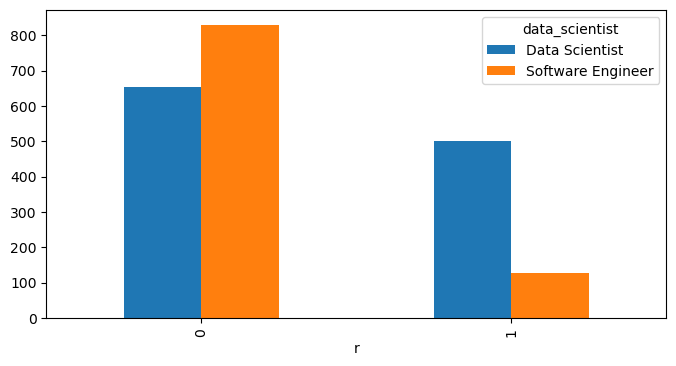

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .assign(data_scientist = kag_y_train)
 .groupby('r')
 .data_scientist
 .value_counts()
 .unstack()
 .plot.bar(ax=ax)
)

plt.show()

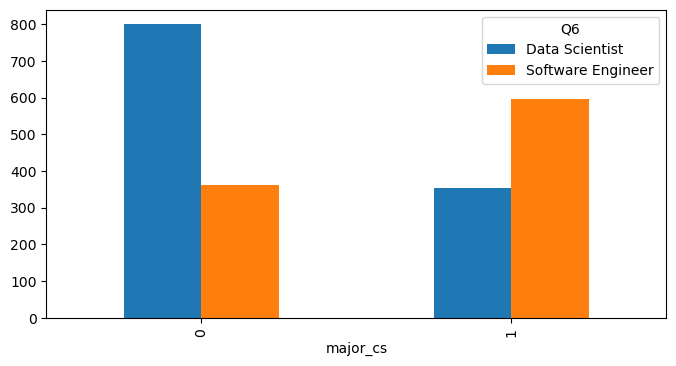

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.crosstab(index=X_train['major_cs'],
             columns=kag_y)
 .plot.bar(ax=ax)
)

plt.show()

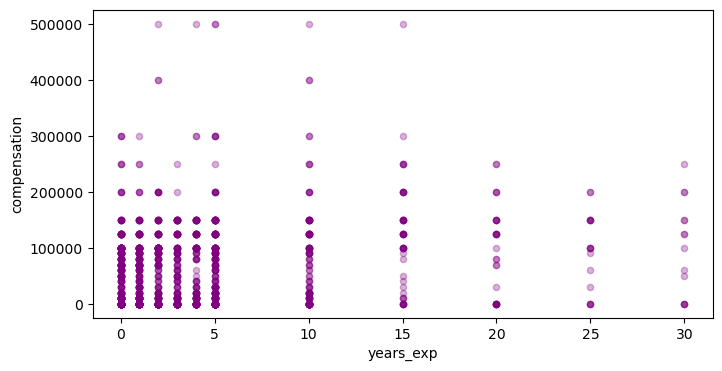

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
)

plt.show()

#### adding Jitter 

In [20]:
import seaborn.objects as so

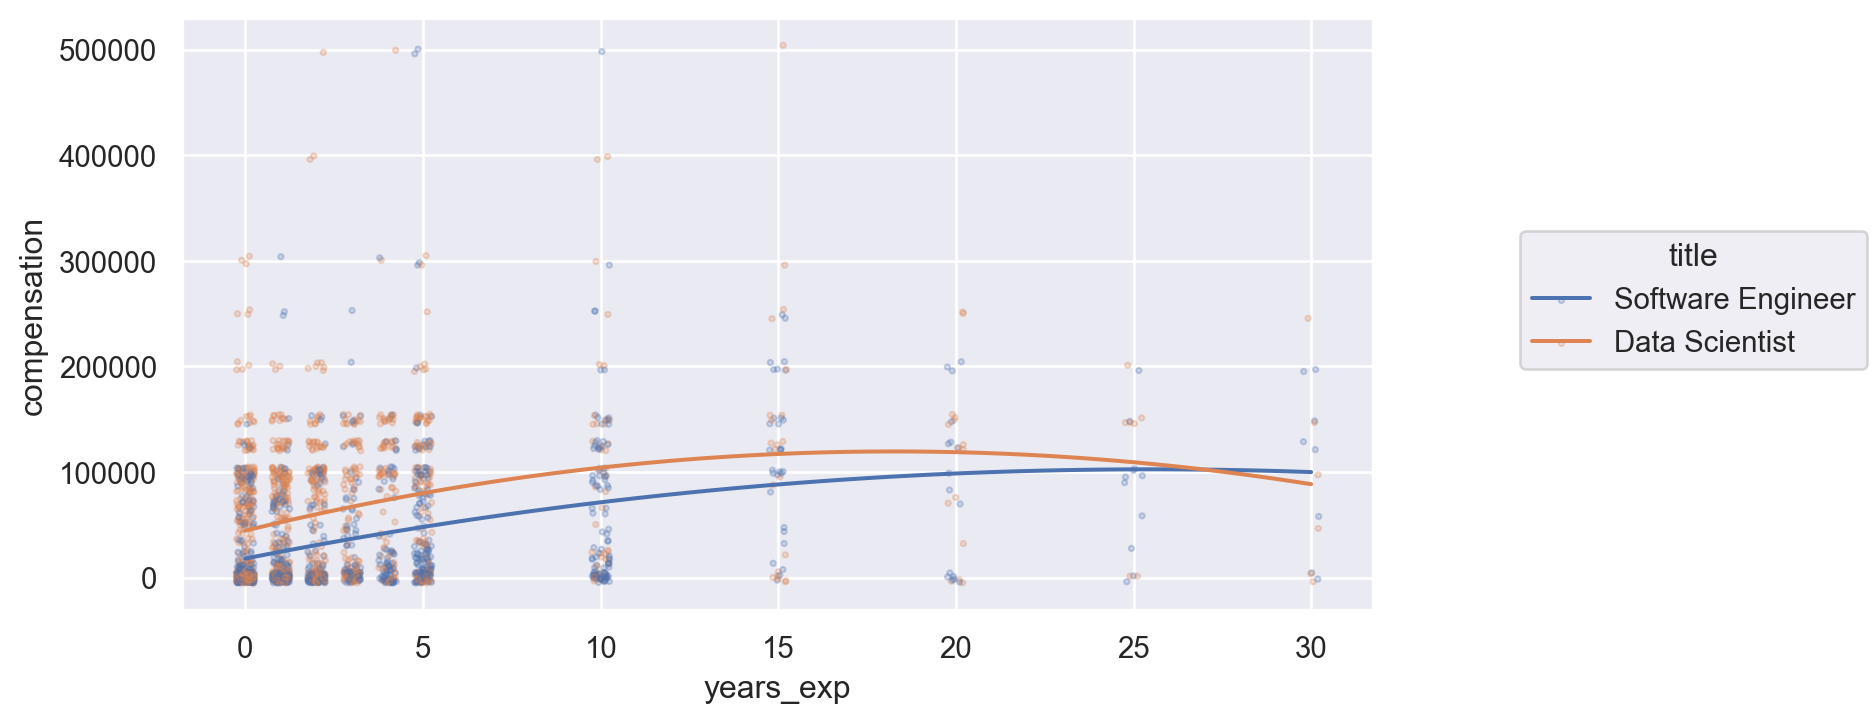

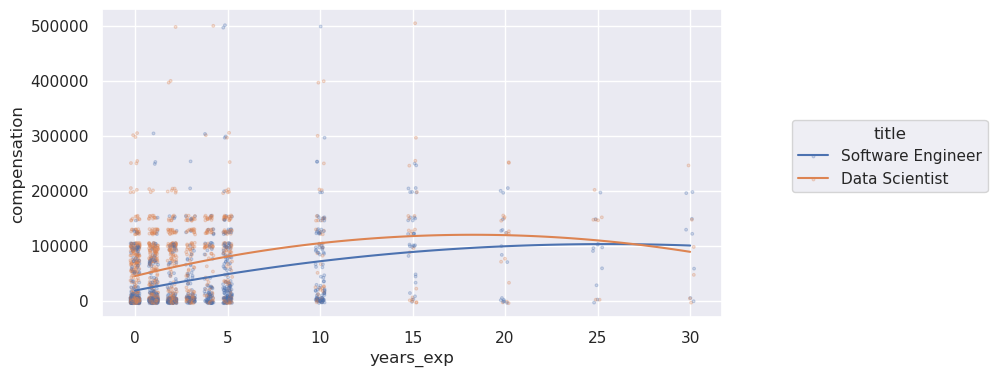

In [21]:
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title')
 .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
 .add(so.Line(), so.PolyFit())
 .on(fig)
 .plot()
)

#### Adjusted Visualization 

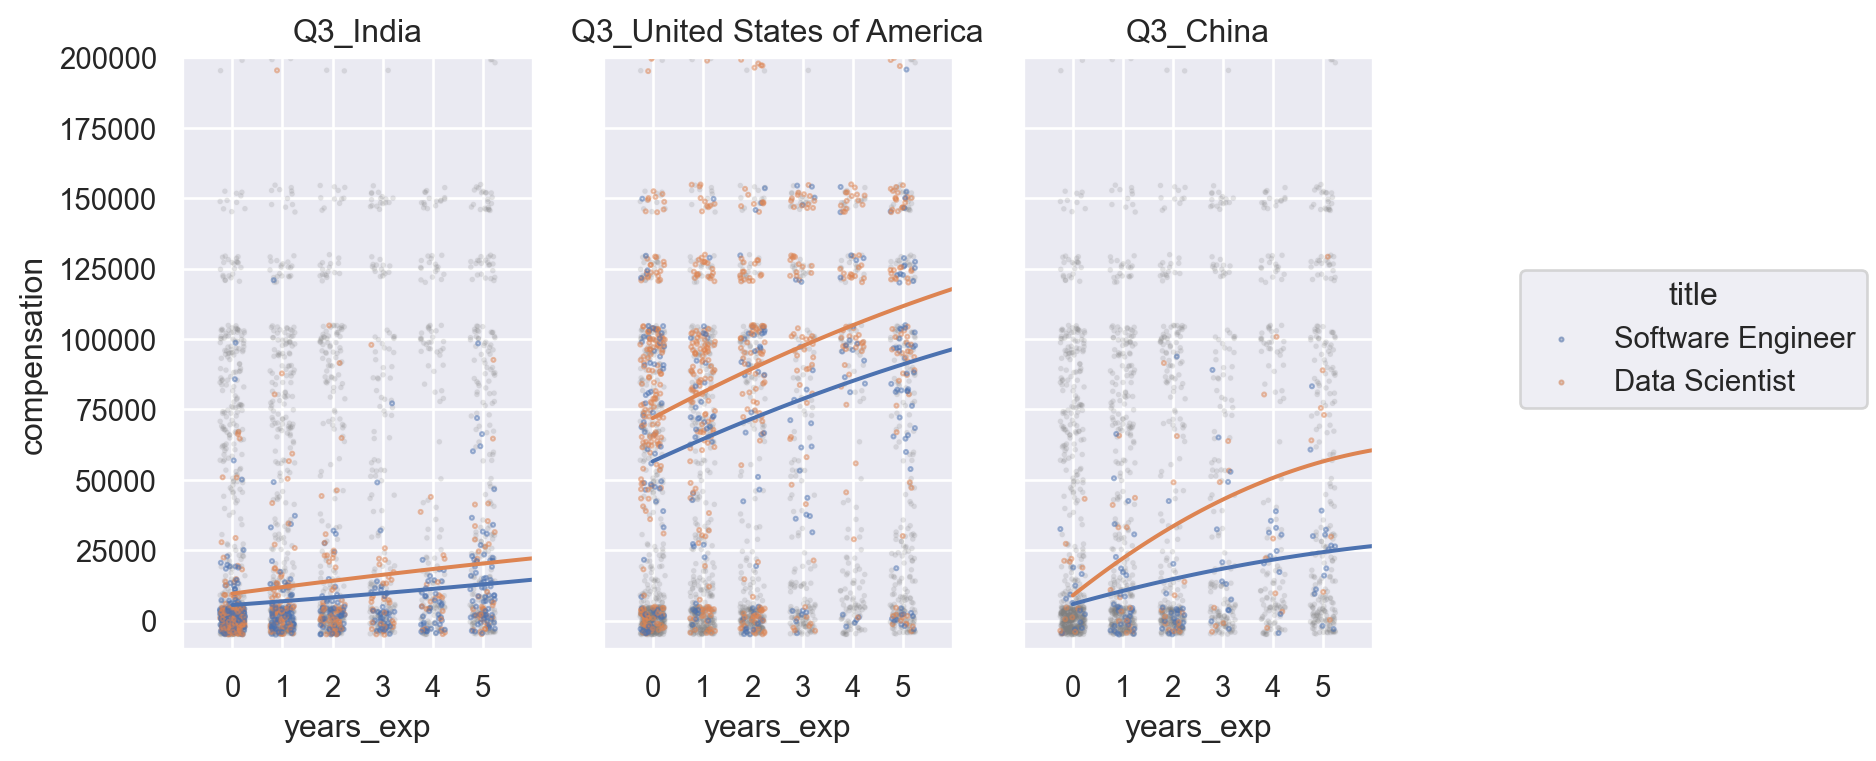

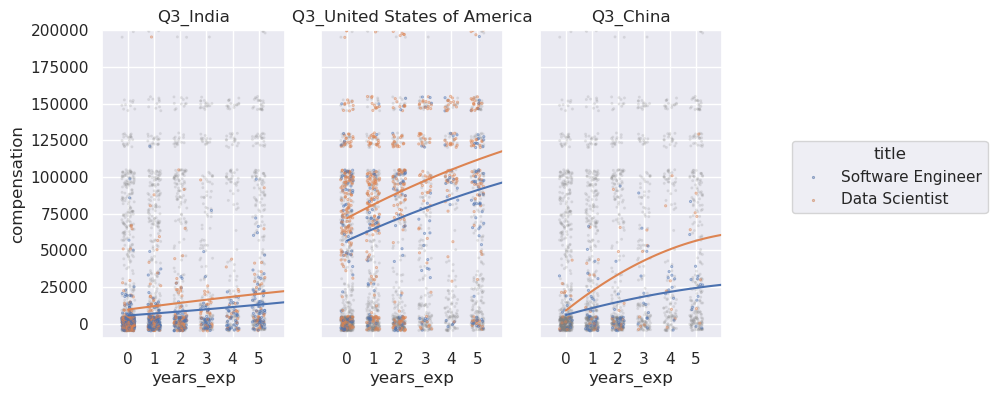

In [22]:
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train
       # .query('compensation < 200_000 and years_exp < 16')
       .assign(
           title=kag_y_train,
           country=(X_train
                    .loc[:, 'Q3_United States of America': 'Q3_China']
                    .idxmax(axis='columns')
                   )
       ), x='years_exp', y='compensation', color='title')
 .facet('country')
 .add(so.Dots(alpha=.01, pointsize=2, color='grey'), so.Jitter(x=.5, y=10_000), col=None)
 .add(so.Dots(alpha=.5, pointsize=1.5), so.Jitter(x=.5, y=10_000))
 .add(so.Line(pointsize=1), so.PolyFit(order=2))
 .scale(x=so.Continuous().tick(at=[0, 1, 2, 3, 4, 5]))
 .limit(y=(-10_000, 200_000), x=(-1, 6))
 .on(fig)
 .plot()
 )

## Tree Creation 

In [23]:
# Numerical Manipualtion
import numpy as np
import numpy.random as rn

In [24]:
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000

rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
gini = pd.DataFrame({'value':
                      np.append((pos_center) + rs.randn(pos_count),
                               (neg_center) + rs.randn(neg_count)),
                      'label':
                      ['pos']* pos_count + ['neg'] * neg_count})

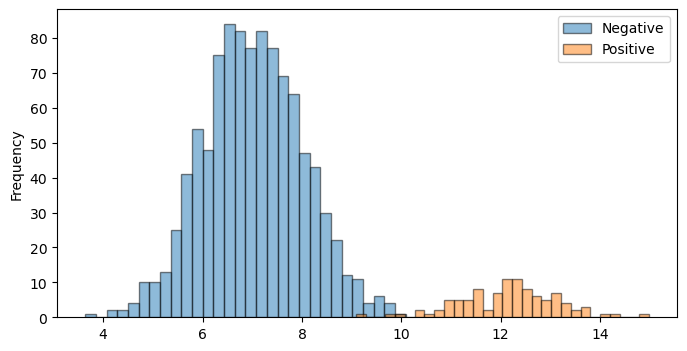

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
     .groupby('label')
     [['value']]
     .plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
    )
ax.legend(['Negative', 'Positive'])

plt.show()

In [26]:
def calc_gini(df, val_col, label_col, pos_val, split_point,
             debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini Impurity
    is a measure of the probability of a random sample being classified
    incorectly when a feature is sued to split the data. The lower the 
    impurity, the better the split.
    
    Parameters:
    df(pd.DataFrame): The dataframe containing the data
    val_col (str): the column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents
        the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
        impurities and the final weighted aveerage
        
    Returns:
    float: The weighted average of Gini impurity for the positive and
        negative subsets.
    """
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    weighted_avg = gini_pos * (pos_size/total_size) * \
    gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:3} {gini_neg=:.3} {weighted_avg=:3}')
    return weighted_avg

In [27]:
calc_gini(gini, val_col='value', label_col='label', pos_val='pos', split_point=9.24, debug=True)

gini_pos=0.21708826063121614 gini_neg=0.00202 weighted_avg=4.050598243782082e-05


4.050598243782082e-05

In [28]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
                          pos_val='pos', split_point=v))

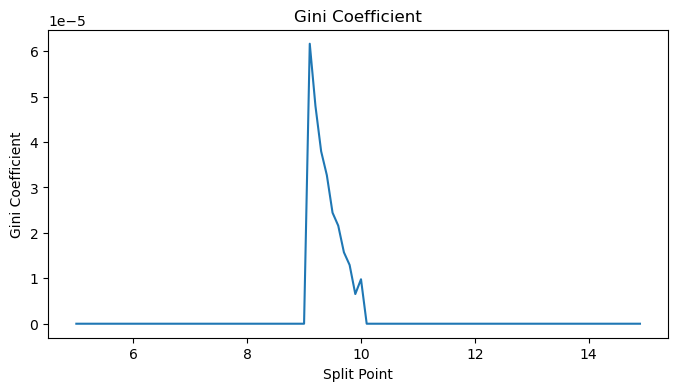

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

plt.show()

In [30]:
pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.000022
9.7     0.000016
9.8     0.000013
9.9     0.000007
10.0    0.000010
10.1    0.000000
10.2    0.000000
10.3    0.000000
10.4    0.000000
10.5    0.000000
dtype: float64

In [31]:
print(pd.DataFrame({'gini':ginis, 'split':values})
      .query('gini <= gini.min()'))

    gini  split
0    0.0    5.0
1    0.0    5.1
2    0.0    5.2
3    0.0    5.3
4    0.0    5.4
..   ...    ...
95   0.0   14.5
96   0.0   14.6
97   0.0   14.7
98   0.0   14.8
99   0.0   14.9

[90 rows x 2 columns]


#### Coeffiecients in Trees

In [32]:
from sklearn import tree
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'value <= 9.708\ngini = 0.165\nsamples = 1100\nvalue = [1000, 100]\nclass = neg'),
 Text(0.25, 0.25, 'gini = 0.002\nsamples = 999\nvalue = [998, 1]\nclass = neg'),
 Text(0.75, 0.25, 'gini = 0.039\nsamples = 101\nvalue = [2, 99]\nclass = pos')]

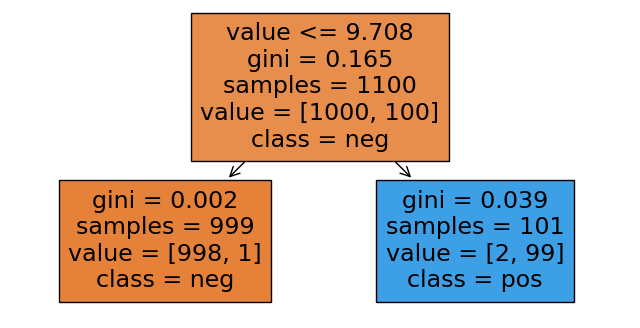

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
tree.plot_tree(stump, feature_names=['value'],
               filled=True, 
               class_names=stump.classes_,
               ax=ax)

In [34]:
gini_pos = 0.039
gini_neg = 0.002
pos_size = 101
neg_size = 999
total_size = pos_size + neg_size
weighted_avg = gini_pos * (pos_size/total_size) + \
gini_neg * (neg_size/total_size)

In [35]:
print(weighted_avg)

0.005397272727272727


In [36]:
import xgboost as xgb

In [37]:
# from graphviz import Digraph

# dot = Digraph(comment='The Round Table')
# dot.node('A', 'King Arthur')
# dot.node('B', 'Sir Bedevere the Wise')
# dot.node('L', 'Sir Lancelot the Brave')

# dot.edges(['AB', 'AL'])
# dot.edge('B', 'L', constraint='false')
# print(dot.source)

In [38]:
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
xg_stump.fit(gini[['value']], (gini.label== 'pos'))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

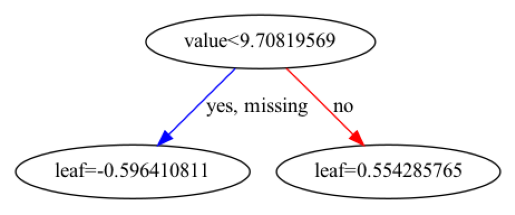

In [39]:
import os
os.environ["PATH"] += os.pathsep + '/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/bin'


xgb.plot_tree(xg_stump, num_trees=0)

plt.show()

In [40]:
import subprocess

def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph 
    visualization in dot and png formats.

    Args:
        xg: An XGBoost model.
        num_trees: The number of tree to export.
        filename: The name of the file to save the exported visualization.
        title: The title to display on the graph visualization (optional).
        direction: The direction to lay out the graph, either 'TB' (top to 
            bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f'''    node [fontname = "Helvetica"];
    edge [fontname = "Helvetica Thin"];
    label = "{title}"
    fontname = "Helvetica"
    '''
    out = res.source.replace('graph [ rankdir=TB ]', 
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot 
    dot_filename = filename
    with open(dot_filename, 'w') as fout:
        fout.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())

In [41]:
my_dot_export(xg_stump, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/stump_xg.dot', title='A demo stump')

#### Another Visualization Tool 

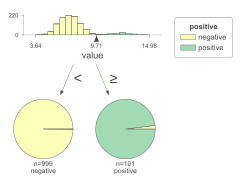

In [42]:
import dtreeviz
viz = dtreeviz.model(xg_stump, X_train=gini[['value']], 
                     y_train=gini.label=='pos',
    target_name='positive',
    feature_names=['value'], class_names=['negative', 'positive'],
    tree_index=0)
viz.view()

## Stumps on Real Data

In [43]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
stump_dt.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.25, 'gini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.75, 0.25, 'gini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist')]

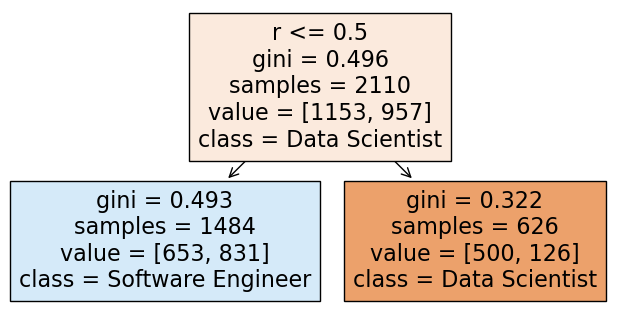

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(stump_dt, feature_names=features,
               filled=True,
               class_names=stump_dt.classes_,
               ax=ax)

In [45]:
X_test = kag_pl.transform(kag_X_test)

In [46]:
stump_dt.score(X_test, kag_y_test)

0.6243093922651933

#### The Dummy Classifier

In [47]:
from sklearn import dummy

In [48]:
dummy_model = dummy.DummyClassifier()

In [49]:
dummy_model.fit(X_train, kag_y_train)

DummyClassifier()

In [50]:
dummy_model.score(X_test, kag_y_test)

0.5458563535911602

In [51]:
import xgboost as xgb

In [52]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_train, kag_y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Data Scientist' 'Software Engineer']

In [ ]:
print(kag_y_train)

In [ ]:
print(kag_y_train == 'Software Engineer')

#### Using Label Encoder

In [53]:
from sklearn import preprocessing

In [54]:
label_encoder = preprocessing.LabelEncoder()

In [55]:
y_train = label_encoder.fit_transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

In [56]:
y_test[:5]

array([1, 0, 0, 1, 1])

In [57]:
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [58]:
# Inverse Tranformation Procedure
label_encoder.inverse_transform([0, 1])

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [59]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [60]:
kag_stump.score(X_test, y_test)

0.6243093922651933

In [61]:
my_dot_export(kag_stump, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/stump_xg.dot',
             title='XGBoost Stump')

In [62]:
kag_stump.classes_

array([0, 1])

In [63]:
def inv_logit(p: float) -> float:
    """
    Compute the inverse logit function of a given value.

    The inverse logit function is defined as:
        f(p) = exp(p) / (1 + exp(p))

    Parameters
    ----------
    p : float
        The input value to the inverse logit function.

    Returns
    -------
    float
        The output of the inverse logit function.
    """
    return np.exp(p) / (1 + np.exp(p))

In [64]:
inv_logit(.07117741922)

0.5177868460919524

In [65]:
inv_logit(-.3592)

0.41115323716754393

Text(-3, 0.4, 'Predict Negative')

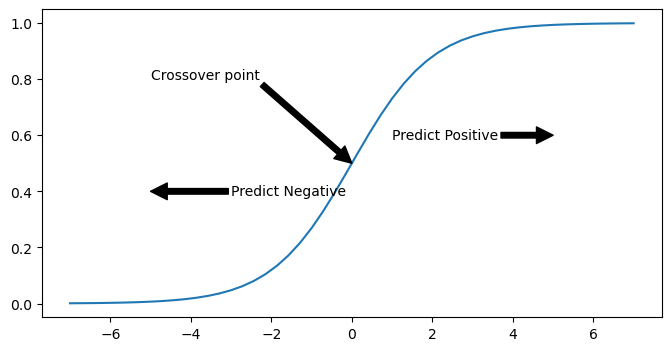

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))
vals = np.linspace(-7, 7)
ax.plot(vals, inv_logit(vals))
ax.annotate('Crossover point', (0,.5), (-5,.8), arrowprops={'color':'k'})
ax.annotate('Predict Positive', (5,.6), (1,.6), va='center', arrowprops={'color':'k'})
ax.annotate('Predict Negative', (-5,.4), (-3,.4), va='center', arrowprops={'color':'k'})

## Model Complexity & Hyperparameters

#### Underfit Model

In [67]:
underfit = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)

In [68]:
underfit.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

In [69]:
underfit.score(X_test, kag_y_test)

0.6243093922651933

#### Overfitting with Decision Trees 

In [70]:
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
X_train = kag_pl.fit_transform(kag_X_train)

In [71]:
hi_variance.fit(X_train, kag_y_train)

DecisionTreeClassifier()

In [72]:
hi_variance.score(X_test, kag_y_test)

0.6629834254143646

[Text(0.6592258023555897, 0.9761904761904762, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]'),
 Text(0.4010276534702394, 0.9285714285714286, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]'),
 Text(0.19823811223369206, 0.8809523809523809, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]'),
 Text(0.08261723039754008, 0.8333333333333334, 'years_exp <= 0.5\ngini = 0.491\nsamples = 322\nvalue = [140, 182]'),
 Text(0.0281133318690973, 0.7857142857142857, 'education <= 17.0\ngini = 0.463\nsamples = 74\nvalue = [47, 27]'),
 Text(0.020206457280913682, 0.7380952380952381, 'major_stat <= 0.5\ngini = 0.499\nsamples = 40\nvalue = [21, 19]'),
 Text(0.018449374039095103, 0.6904761904761905, 'age <= 27.5\ngini = 0.5\nsamples = 38\nvalue = [19, 19]'),
 Text(0.01669229079727652, 0.6428571428571429, 'compensation <= 55000.0\ngini = 0.498\nsamples = 36\nvalue = [17, 19]'),
 Text(0.014935207555457939, 0.5952380952380952, 'compensation <=

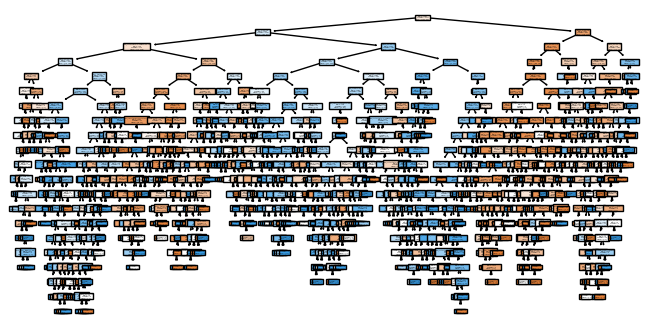

In [73]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True)

[Text(0.5, 0.875, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.125, 0.375, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]\nclass = Data Scientist'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'years_exp <= 2.5\ngini = 0.433\nsamples = 766\nvalue = [243, 523]\nclass = Software Engineer'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'major_cs <= 0.5\ngini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist'),
 Text(0.625, 0.375, 'years_exp <= 22.5\ngini = 0.211\nsamples = 443\nvalue = [390, 53]\nclass = Data Scientist'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'years_exp <= 7.5\ngini = 0.48\nsamples = 183\nval

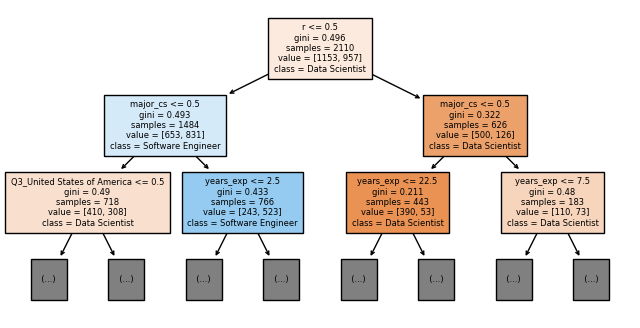

In [74]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True, class_names=hi_variance.classes_,
              max_depth=2, fontsize=6)

## Tree Hyperparameters 

In [75]:
stump.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

#### Tracking changes with Validation Curves

In [76]:
accuracies = []
for depth in range(1, 15):
    between = tree.DecisionTreeClassifier(max_depth=depth)
    between.fit(X_train, kag_y_train)
    accuracies.append(between.score(X_test, kag_y_test))

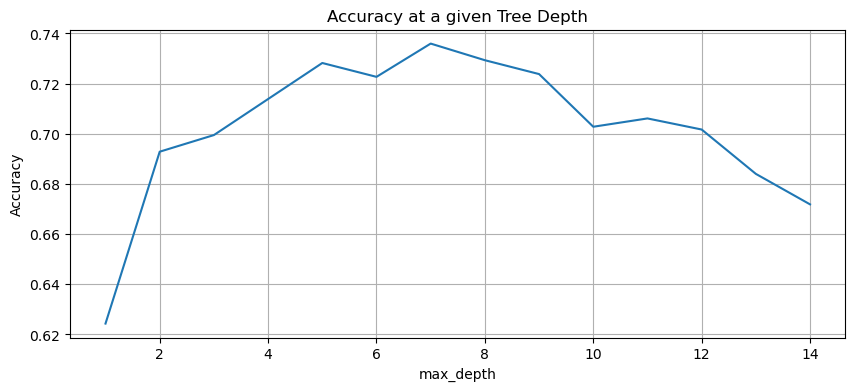

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))
(pd.Series(accuracies, name='Accuracy', index=range(1, len(accuracies)+1))
 .plot(ax=ax, title='Accuracy at a given Tree Depth'))
ax.set_ylabel('Accuracy')
ax.set_xlabel('max_depth')

plt.grid(True)
plt.show()

In [78]:
between = tree.DecisionTreeClassifier(max_depth=7)
between.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=7)

In [79]:
between.score(X_test, kag_y_test)

0.7337016574585635

#### Leveraging Yellowbrick

In [80]:
from yellowbrick.model_selection import validation_curve

/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/

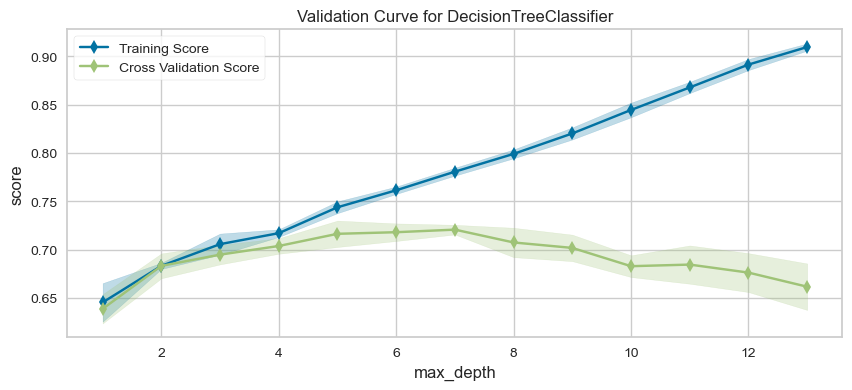

In [81]:
fig, ax = plt.subplots(figsize=(10, 4))
viz = validation_curve(tree.DecisionTreeClassifier(),
                       X=pd.concat([X_train, X_test]),
                       y=pd.concat([kag_y_train, kag_y_test]),
                       param_name='max_depth', param_range=range(1, 14),
                       scoring='accuracy', cv=5, ax=ax, n_jobs=6)

plt.show()

#### Grid Search 

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
params = {
    'max_depth': [3, 5, 7, 8],
    'min_samples_leaf': [1, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6],
}

In [84]:
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(),
                           param_grid=params, cv=4, n_jobs=-1,
                           verbose=1, scoring="accuracy")

In [85]:
grid_search.fit(pd.concat([X_train, X_test]),
                pd.concat([kag_y_train, kag_y_test]))

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [1, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=1)

In [86]:
grid_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [87]:
between2 = tree.DecisionTreeClassifier(**grid_search.best_params_)

In [88]:
between2.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5)

In [89]:
between2.score(X_test, kag_y_test)

0.7259668508287292

In [90]:
(pd.DataFrame(grid_search.cv_results_)
 .sort_values(by='rank_test_score')
 .style
 .background_gradient(axis='rows')
)

In [91]:
results = model_selection.cross_val_score(
    tree.DecisionTreeClassifier(max_depth=7),
    X=pd.concat([X_train, X_test], axis='index'),
    y=pd.concat([kag_y_train, kag_y_test], axis='index'),
    cv=4
)

In [92]:
results

array([0.69628647, 0.73607427, 0.70424403, 0.71447543])

In [93]:
results.mean()

0.7127700515356787

In [94]:
results = model_selection.cross_val_score(
    tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=5,
                               min_samples_split=2),
    X=pd.concat([X_train, X_test], axis='index'),
    y=pd.concat([kag_y_train, kag_y_test], axis='index'),
    cv=4
)

In [95]:
results

array([0.70689655, 0.74005305, 0.71220159, 0.71580345])

In [96]:
results.mean()

0.7187386616222995

## Random Forest

#### Scikit-Learn Random Forest

In [97]:
from sklearn import ensemble

In [98]:
rf = ensemble.RandomForestClassifier(random_state=42)

In [99]:
rf.fit(X_train, kag_y_train)

RandomForestClassifier(random_state=42)

In [100]:
rf.score(X_test, kag_y_test)

0.7237569060773481

In [101]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [102]:
len(rf.estimators_)

100

In [103]:
print(rf.estimators_[0])

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)


[Text(0.5, 0.875, 'Q3_United States of America <= 0.5\ngini = 0.496\nsamples = 1354\nvalue = [1146, 964]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'r <= 0.5\ngini = 0.496\nsamples = 681\nvalue = [496, 588]\nclass = Software Engineer'),
 Text(0.125, 0.375, 'education <= 17.0\ngini = 0.469\nsamples = 530\nvalue = [317, 528]\nclass = Software Engineer'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'education <= 17.0\ngini = 0.376\nsamples = 151\nvalue = [179, 60]\nclass = Data Scientist'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'education <= 17.0\ngini = 0.464\nsamples = 673\nvalue = [650, 376]\nclass = Data Scientist'),
 Text(0.625, 0.375, 'major_cs <= 0.5\ngini = 0.485\nsamples = 176\nvalue = [109, 154]\nclass = Software Engineer'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'major_cs <= 0.5\ngini = 0.413\nsamples = 49

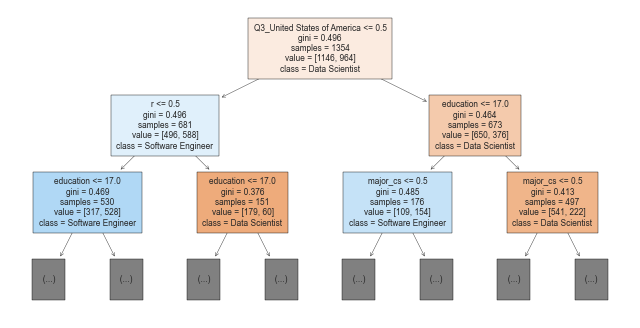

In [104]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(rf.estimators_[0], feature_names=features,
               filled=True, class_names=rf.classes_, ax=ax,
               max_depth=2, fontsize=6)

#### XGBoost Random Forest 

In [105]:
import xgboost as xgb

In [106]:
rf_xg = xgb.XGBRFClassifier(random_state=42)

In [107]:
rf_xg.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=42,
                reg_alpha=None, ...)

In [108]:
rf_xg.score(X_test, y_test)

0.7447513812154696

In [109]:
rf_xg.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

<Axes: >

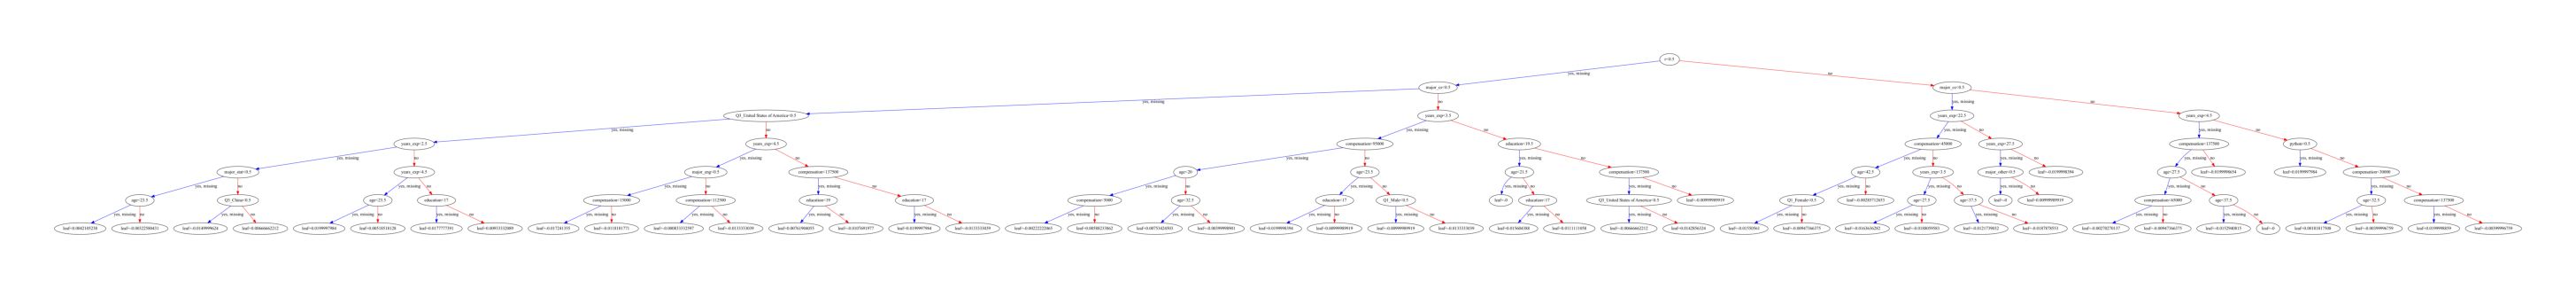

In [110]:
fig, ax = plt.subplots(figsize=(6, 12), dpi=600)
xgb.plot_tree(rf_xg, num_trees=0, ax=ax, size='1, 1')

In [111]:
my_dot_export(rf_xg, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/big_tree_xg.dot',
              title='First Random Forest Tree')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.960825 to fit


In [112]:
viz = dtreeviz.model(rf_xg, X_train=X_train,
                     y_train=y_train,
                     target_name='Job', feature_names=list(X_train.columns),
                     class_names=['DS', 'SE'], tree_index=0)

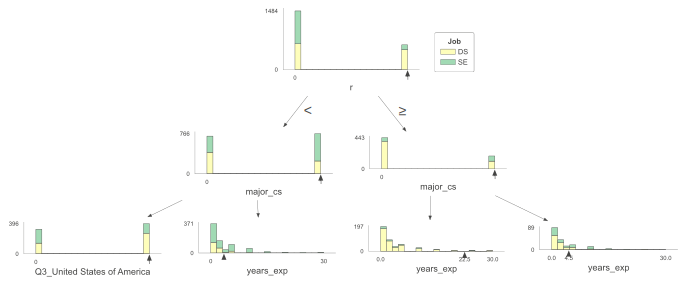

In [113]:
viz.view(depth_range_to_display=[0, 2])

#### Training the Number of Trees in the Forest

In [114]:
from yellowbrick.model_selection import validation_curve

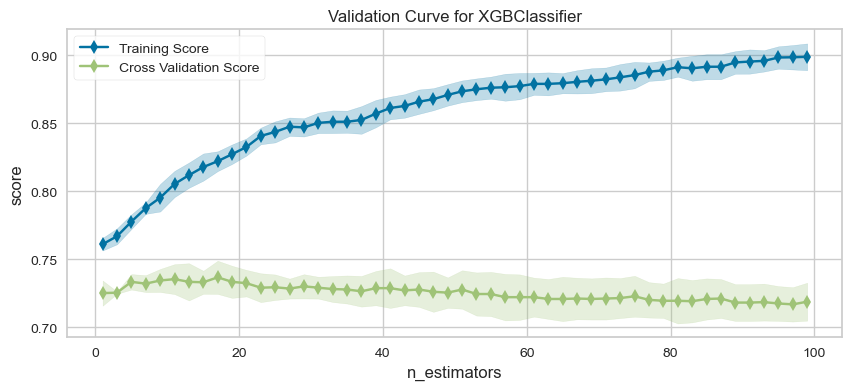

In [115]:
fig, ax = plt.subplots(figsize=(10, 4))
viz = validation_curve(xgb.XGBClassifier(random_state=42),
                       X=pd.concat([X_train, X_test], axis='index'),
                       y=np.concatenate([y_train, y_test]),
                       param_name='n_estimators', param_range=range(1, 100, 2),
                       scoring='accuracy', cv=3,
                       ax=ax)

In [116]:
rf_xg29 = xgb.XGBClassifier(random_state=42, n_estimators=29)

In [117]:
rf_xg29.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=29, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [118]:
rf_xg29.score(X_test, y_test)

0.7591160220994475

## XGBoost

#### Creating an XGBoost Model

In [119]:
%matplotlib inline

# Visualization 
import dtreeviz
import matplotlib.pyplot as plt
# Feature Engineering
from feature_engine import encoding, imputation
# Numerical Manipulation
import numpy as np
# Data Manipulation
import pandas as pd

In [120]:
# Machine Learning Libraries

from sklearn import base, compose, datasets, ensemble, \
metrics, model_selection, pipeline, preprocessing, tree

In [121]:
# Scikit Plotting
import scikitplot
# Extreme Gradient Boosting
import xgboost as xgb
# Sensical Visualizer & Classifier
import yellowbrick.model_selection as ms
from yellowbrick import classifier

In [122]:
# Retrieving Data

import urllib
import zipfile

In [123]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [124]:
# Function Extration
def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file & read it into pandas
    DataFrame.
    
    Parameters:
        src '(str:)' URL of the zip file to be downloaded and extrated.
        dst 'str': Local file path where the zip file will be written.
        member_name: Name of the member file inside the zip file to be
            read into a DataFrame.
            
    Returns:
        pandas.DataFrame containing the contents of member file.
    """
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

In [125]:
raw = extract_zip(url, fname, member_name)

/var/folders/wh/l_q69dcj75z0c82jy8ry71f40000gn/T/ipykernel_63035/3680407660.py:22: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


In [126]:
## Create raw X and raw y
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [127]:
## Split data    
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
    model_selection.train_test_split(
        kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)  

In [128]:
## Transform X with pipeline
X_train = kag_pl.fit_transform(kag_X_train)
X_test = kag_pl.transform(kag_X_test)

In [129]:
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

In [130]:
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

#### A Boosted Model

In [131]:
xg_oob = xgb.XGBClassifier()

In [132]:
xg_oob.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [133]:
xg_oob.score(X_test, y_test)

0.7458563535911602

In [134]:
# Let's try with depth of 2 and 2 trees

xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)

In [135]:
xg2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [136]:
xg2.score(X_test, y_test)

0.6685082872928176

In [137]:
# Let's visualize it

viz = dtreeviz.model(xg2, X_train=X, y_train=y, target_name='Job',
                     feature_names=list(X_train.columns),
                     class_names=['DS', 'SE'], tree_index=0)

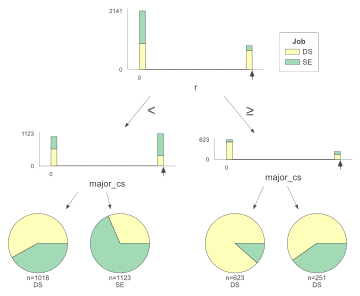

In [138]:
viz.view(depth_range_to_display=[0, 2])

#### Understanding the Output of the Trees

In [139]:
my_dot_export(xg2, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/tree_2_xg.dot', title='First Tree')

<Axes: >

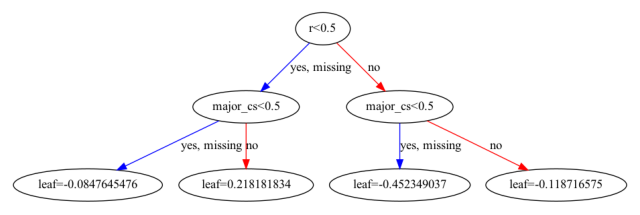

In [140]:
xgb.plot_tree(xg2, num_trees=0)

In [141]:
# Predicts 1 - Software engineer

se7894 = pd.DataFrame({'age': {7894: 22},
                       'education': {7894:16.0},
                       'years_exp': {7894: 1.0},
                       'compensation': {7894: 0},
                       'python': {7894:1},
                       'r':{7894: 0},
                       'sql':{7894: 0},
                       'Q1_Male':{7894: 1},
                       'Q1_Female': {7894: 0},
                       'Q1_Prefer not to say': {7894: 0},
                       'Q1_Prefer to self-describe': {7894: 0},
                       'Q3_United States of America': {7894: 0},
                       'Q3_India': {7894: 1},
                       'Q3_China': {7894: 0},
                       'major_cs': {7894: 0},
                       'major_other': {7894: 0},
                       'major_eng': {7894: 0},
                       'major_stat': {7894: 0}})

In [142]:
xg2.predict_proba(se7894)

array([[0.4986236, 0.5013764]], dtype=float32)

In [143]:
xg2.predict(pd.DataFrame(se7894))

array([1])

In [144]:
my_dot_export(xg2, num_trees=1, filename='/Users/isisromero/Desktop/img_XGB/tree_3_xg.dot', title='Second Tree')

<Axes: >

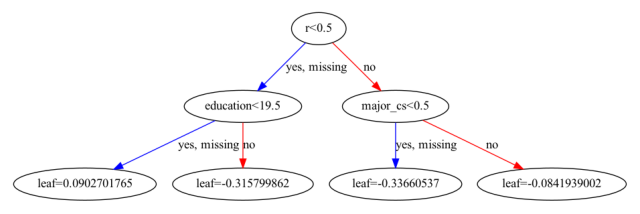

In [145]:
xgb.plot_tree(xg2, num_trees=1)

In [146]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [147]:
inv_logit(-0.08476+0.0902701)

0.5013775215147345

## Early Stopping

#### Early stopping Rounds

In [148]:
# Defaults
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [149]:
xg.score(X_test, y_test)

0.7458563535911602

In [150]:
xg = xgb.XGBClassifier(early_stopping_rounds=20)
xg.fit(X_train, y_train,
       eval_set=[(X_train, y_train),
                 (X_test, y_test)
                ]
      )

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[1]	validation_0-logloss:0.57046	validation_1-logloss:0.57623
[2]	validation_0-logloss:0.54011	validation_1-logloss:0.55333
[3]	validation_0-logloss:0.51965	validation_1-logloss:0.53711
[4]	validation_0-logloss:0.50419	validation_1-logloss:0.52511
[5]	validation_0-logloss:0.49176	validation_1-logloss:0.51741
[6]	validation_0-logloss:0.48159	validation_1-logloss:0.51277
[7]	validation_0-logloss:0.47221	validation_1-logloss:0.51040
[8]	validation_0-logloss:0.46221	validation_1-logloss:0.50713
[9]	validation_0-logloss:0.45700	validation_1-logloss:0.50583
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[11]	validation_0-logloss:0.44533	validation_1-logloss:0.50338
[12]	validation_0-logloss:0.43736	validation_1-logloss:0.50033
[13]	validation_0-logloss:0.43399	validation_1-logloss:0.50034
[14]	validation_0-logloss:0.43004	validation_1-logloss:0.50192
[15]	validation_0-logloss:0.42550	validation_1-logloss:0.50268
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [151]:
xg.score(X_test, y_test)

0.7558011049723757

In [152]:
xg.best_ntree_limit

13

#### Plotting Tree Performance

In [153]:
results = xg.evals_result()
results

{'validation_0': OrderedDict([('logloss',
               [0.6153406503923696,
                0.570456665259967,
                0.5401074953836288,
                0.519646179894983,
                0.5041859194636344,
                0.49175883369140716,
                0.48158584668243665,
                0.47221356730254904,
                0.46221246071407013,
                0.4570046101436372,
                0.4506211909637632,
                0.4453310158703988,
                0.4373589512737583,
                0.4339914069144647,
                0.4300442739147075,
                0.4255026599652712,
                0.4216894939687474,
                0.4185393191472367,
                0.41485192587387293,
                0.4122836277407475,
                0.4087179541126582,
                0.4048982679969697,
                0.4027963529939,
                0.39941699937851083,
                0.3980718078018912,
                0.39473153130025534,
                0.39

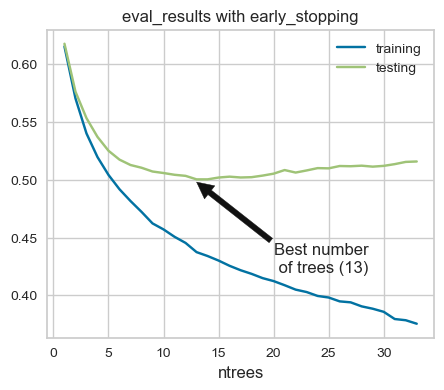

In [154]:
# Testing score is best at 13 trees
results = xg.evals_result()

fig, ax = plt.subplots(figsize=(8, 4))
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
                    'testing': results['validation_1']['logloss']})
      .assign(ntrees=lambda adf: range(1, len(adf)+1))
      .set_index('ntrees')
      .plot(figsize=(5, 4), ax=ax,
           title='eval_results with early_stopping')
     )
ax.annotate('Best number \n of trees (13)', xy=(13, .498),
           xytext=(20,.42), arrowprops={'color': 'k'})

ax.set_label('ntrees')

In [155]:
xg13 = xgb.XGBClassifier(n_estimators=13)
xg13.fit(X_train, y_train,
         eval_set=[(X_train, y_train),
                   (X_test, y_test)]
        )

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[1]	validation_0-logloss:0.57046	validation_1-logloss:0.57623
[2]	validation_0-logloss:0.54011	validation_1-logloss:0.55333
[3]	validation_0-logloss:0.51965	validation_1-logloss:0.53711
[4]	validation_0-logloss:0.50419	validation_1-logloss:0.52511
[5]	validation_0-logloss:0.49176	validation_1-logloss:0.51741
[6]	validation_0-logloss:0.48159	validation_1-logloss:0.51277
[7]	validation_0-logloss:0.47221	validation_1-logloss:0.51040
[8]	validation_0-logloss:0.46221	validation_1-logloss:0.50713
[9]	validation_0-logloss:0.45700	validation_1-logloss:0.50583
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[11]	validation_0-logloss:0.44533	validation_1-logloss:0.50338
[12]	validation_0-logloss:0.43736	validation_1-logloss:0.50033


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=13, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [156]:
xg13.score(X_test, y_test)

0.7558011049723757

In [157]:
# No early stopping uses all estimators
xg_no_es = xgb.XGBClassifier()
xg_no_es.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [158]:
xg_no_es.score(X_test, y_test)

0.7458563535911602

In [159]:
xg_err = xgb.XGBClassifier(early_stopping_rounds=20,
                          eval_metric='error')

In [160]:
xg_err.fit(X_train, y_train,
           eval_set=[(X_train, y_train),
                     (X_test, y_test)]
          )

[0]	validation_0-error:0.24739	validation_1-error:0.27072
[1]	validation_0-error:0.24218	validation_1-error:0.26188
[2]	validation_0-error:0.23839	validation_1-error:0.24751
[3]	validation_0-error:0.23697	validation_1-error:0.25193
[4]	validation_0-error:0.23081	validation_1-error:0.24530
[5]	validation_0-error:0.22607	validation_1-error:0.24420
[6]	validation_0-error:0.22180	validation_1-error:0.24862
[7]	validation_0-error:0.21801	validation_1-error:0.24862
[8]	validation_0-error:0.21280	validation_1-error:0.25304
[9]	validation_0-error:0.21043	validation_1-error:0.25304
[10]	validation_0-error:0.20806	validation_1-error:0.24641
[11]	validation_0-error:0.20284	validation_1-error:0.25193
[12]	validation_0-error:0.20047	validation_1-error:0.24420
[13]	validation_0-error:0.19668	validation_1-error:0.24420
[14]	validation_0-error:0.19384	validation_1-error:0.24530
[15]	validation_0-error:0.18815	validation_1-error:0.24199
[16]	validation_0-error:0.18531	validation_1-error:0.24199
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [161]:
xg_err.score(X_test, y_test)

0.7624309392265194

In [162]:
xg_err.best_ntree_limit

19

## XGBoost Hyperparameters

#### Examining Hyperparameters

In [163]:
xg = xgb.XGBClassifier() #set the hyperparameters in here
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [164]:
xg.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

#### Tuning Hyperparameters

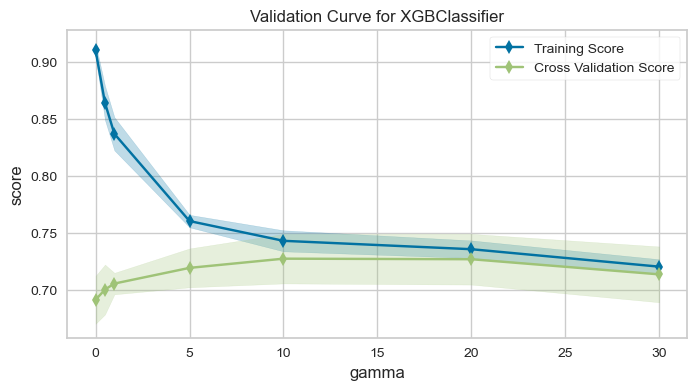

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='gamma', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=No...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                n_jobs=-1, param_name='gamma',
                param_range=array([ 0. ,  0.5,  1. ,  5. , 10. , 20. , 30. ]))

In [165]:
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, param_name='gamma',
                    param_range=[0, .5, 1, 5, 10, 20, 30], n_jobs=-1, ax=ax)

#### Intuitive Understanding of Learning Rate

In [166]:
# Check impact of learning weight on scores
xg_lr1 = xgb.XGBClassifier(learning_rate=1, max_depth=2)
xg_lr1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [167]:
my_dot_export(xg_lr1, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/xg_depth2_tree0.dot', title='Learning Rate set to 1')

<Axes: >

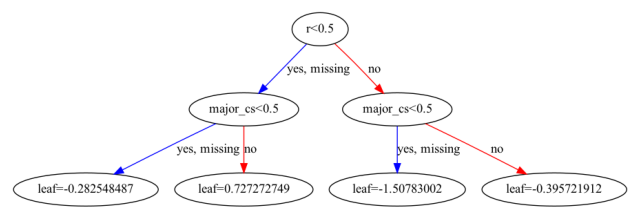

In [168]:
xgb.plot_tree(xg_lr1, num_trees=0)

In [169]:
# Reducing Learning Rate
xg_lr001 = xgb.XGBClassifier(learning_rate=.001, max_depth=2)
xg_lr001.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [170]:
my_dot_export(xg_lr1, num_trees=0, filename='/Users/isisromero/Desktop/img_XGB/xg_depth2_tree0_lr001.dot',
              title='Learning Rate set to .001')

<Axes: >

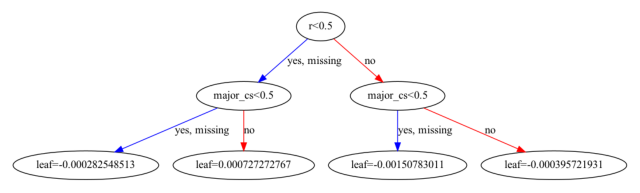

In [171]:
xgb.plot_tree(xg_lr001, num_trees=0)

#### Grid Search

In [172]:
from sklearn import model_selection

In [173]:
params = {'reg_lambda': [0],
          'learning_rate': [.1, .3],
          'subsample': [.7, 1],
          'max_depth': [2, 3],
          'random_state': [42],
          'n_jobs': [-1],
          'n_estimators': [200]}

In [174]:
xgb2 = xgb.XGBClassifier(early_stopping_rounds=5)

In [175]:
cv = (model_selection.GridSearchCV(xgb2, params, cv=3, n_jobs=-1)
      .fit(X_train, y_train,
           eval_set=[(X_test, y_test)],
           verbose=50
          )
     )

[0]	validation_0-logloss:0.67687
[0]	validation_0-logloss:0.67559
[0]	validation_0-logloss:0.67565
[0]	validation_0-logloss:0.67504
[50]	validation_0-logloss:0.52101
[50]	validation_0-logloss:0.52479
[50]	validation_0-logloss:0.51775
[67]	validation_0-logloss:0.51397
[75]	validation_0-logloss:0.51643
[0]	validation_0-logloss:0.67638
[50]	validation_0-logloss:0.52950
[0]	validation_0-logloss:0.67500
[100]	validation_0-logloss:0.50297
[96]	validation_0-logloss:0.52198
[50]	validation_0-logloss:0.52789
[50]	validation_0-logloss:0.52412
[0]	validation_0-logloss:0.67246
[76]	validation_0-logloss:0.52156
[137]	validation_0-logloss:0.50025
[0]	validation_0-logloss:0.67345
[0]	validation_0-logloss:0.67214
[100]	validation_0-logloss:0.51087
[122]	validation_0-logloss:0.50820
[50]	validation_0-logloss:0.51417
[0]	validation_0-logloss:0.67210
[50]	validation_0-logloss:0.50347
[50]	validation_0-logloss:0.51197
[52]	validation_0-logloss:0.51103
[72]	validation_0-logloss:0.50962
[0]	validation_0-log

In [176]:
cv.best_params_

{'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

In [177]:
params = {'learning_rate': 0.3,
          'max_depth': 2,
          'n_estimators': 200,
          'n_jobs': -1,
          'random_state': 42,
          'reg_lambda': 0,
          'subsample': 1}

In [178]:
xgb_grid = xgb.XGBClassifier(**params, early_stopping_rounds=50)

In [179]:
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train),
                                         (X_test, y_test)],
             verbose=10
            )

[0]	validation_0-logloss:0.64709	validation_1-logloss:0.64544
[10]	validation_0-logloss:0.54430	validation_1-logloss:0.53771
[20]	validation_0-logloss:0.52311	validation_1-logloss:0.51780
[30]	validation_0-logloss:0.51253	validation_1-logloss:0.51011
[40]	validation_0-logloss:0.50731	validation_1-logloss:0.50763
[50]	validation_0-logloss:0.50150	validation_1-logloss:0.50626
[60]	validation_0-logloss:0.49832	validation_1-logloss:0.50483
[70]	validation_0-logloss:0.49528	validation_1-logloss:0.50508
[80]	validation_0-logloss:0.49255	validation_1-logloss:0.50703
[90]	validation_0-logloss:0.48966	validation_1-logloss:0.50807
[100]	validation_0-logloss:0.48718	validation_1-logloss:0.50778
[110]	validation_0-logloss:0.48625	validation_1-logloss:0.50810
[111]	validation_0-logloss:0.48600	validation_1-logloss:0.50789


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [180]:
# Training Default
xgb_def = xgb.XGBClassifier(early_stopping_rounds=50)

In [181]:
xgb_def.fit(X_train, y_train, eval_set=[(X_train, y_train),
                                        (X_test, y_test)],
            verbose=10
           )

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[20]	validation_0-logloss:0.40872	validation_1-logloss:0.50839
[30]	validation_0-logloss:0.37945	validation_1-logloss:0.51352
[40]	validation_0-logloss:0.35009	validation_1-logloss:0.52234
[50]	validation_0-logloss:0.33692	validation_1-logloss:0.52726
[60]	validation_0-logloss:0.32142	validation_1-logloss:0.53397
[61]	validation_0-logloss:0.32072	validation_1-logloss:0.53429


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [182]:
xgb_def.score(X_test, y_test), xgb_grid.score(X_test, y_test)

(0.7558011049723757, 0.7524861878453039)

In [183]:
# Default Model Cross-Validation
results_default = model_selection.cross_val_score(
    xgb.XGBClassifier(),
    X=X, y=y,
    cv=4
)

In [184]:
results_default

array([0.71352785, 0.72413793, 0.69496021, 0.74501992])

In [185]:
results_grid = model_selection.cross_val_score(
    xgb.XGBClassifier(**params),
    X=X, y=y,
    cv=4
)

In [186]:
results_grid

array([0.74137931, 0.74137931, 0.74801061, 0.73572377])

In [187]:
results_grid.mean()

0.7416232505873941

## Hyperopt

#### Exhaustive Tuning with Hyperopt

In [188]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score  

from typing import Any, Dict, Union

In [189]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]], 
                    X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series, 
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.

    This function takes a dictionary of hyperparameters, training 
    and test data, and an optional value for early stopping rounds, 
    and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training 
    data and evaluated on the test data. The loss is computed as 
    the negative of the accuracy score.

    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value 
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy

    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the 
        tuning process. The loss is a float, and the model is an 
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation, 
              verbose=False)    

    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [190]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -7, 0),  # boosting
    'random_state': 42
}

In [191]:
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, 
                                                   X_test, y_test),            
    space=options,           
    algo=tpe.suggest,            
    max_evals=2_000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
)

100%|████| 2000/2000 [14:03<00:00,  2.37trial/s, best loss: -0.7767955801104972]


In [200]:
# # 2 hours of training (paste best in here)
# long_params = {'colsample_bytree': 0.6874845219014455, 
#                'gamma': 0.06936323554883501, 
#                'learning_rate': 0.21439214284976907, 
#                'max_depth': 6, 
#                'min_child_weight': 0.6678357091609912, 
#                'reg_alpha': 3.2979862933185546, 
#                'reg_lambda': 7.850943400390477, 
#                'subsample': 0.999767483950891}

In [201]:
# xg_ex = xgb.XGBClassifier(**long_params, early_stopping_rounds=50,
#                             n_estimators=500)

In [202]:
# xg_ex.fit(X_train, y_train,
#        eval_set=[(X_train, y_train),
#                  (X_test, y_test)
#                 ],
#         verbose=100
#       )

In [203]:
# xg_ex.score(X_test, y_test)

#### Defining Parameter Distributions

In [204]:
from hyperopt import hp, pyll

In [205]:
pyll.stochastic.sample(hp.choice('value', ['a', 'b', 'c']))

'a'

In [206]:
pyll.stochastic.sample(hp.choice('value', [(0.5, 'a'), (.9, 'b'), (.05, 'c')]))

(0.05, 'c')

In [207]:
pyll.stochastic.sample(hp.uniform('value', 0, 1))

0.48795366094212755

In [208]:
uniform_vals = [pyll.stochastic.sample(hp.uniform('value', 0, 1))
                for _ in range(10_000)]

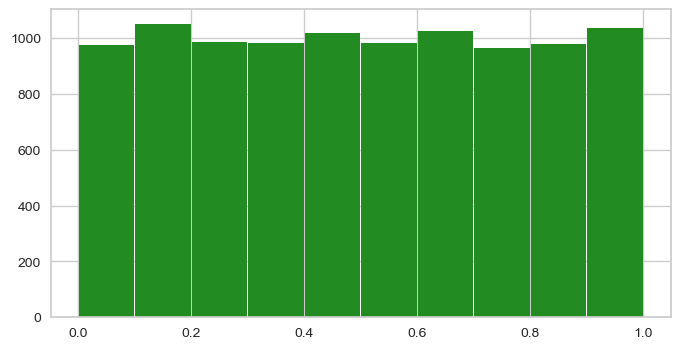

In [209]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals, bins=10, rwidth=0.98, color='forestgreen')
plt.show()

In [210]:
loguniform_vals = [pyll.stochastic.sample(hp.loguniform('value', -5, 5))
                   for _ in range(10_000)]

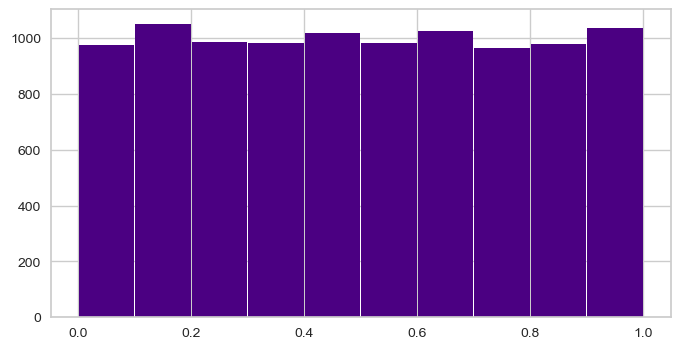

In [211]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(uniform_vals, bins=10, rwidth=0.98, color='indigo')
plt.show()

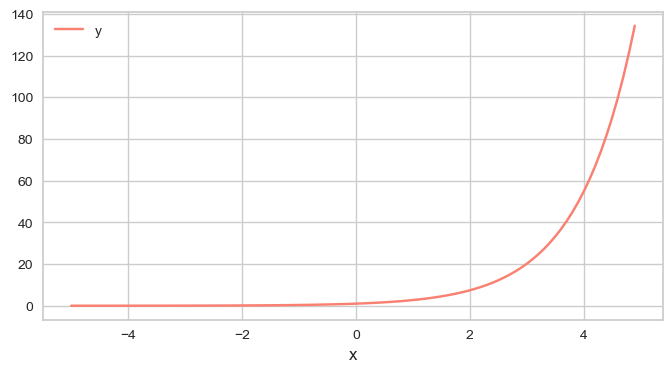

In [212]:
fig, ax = plt.subplots(figsize=(8, 4))

(pd.Series(np.arange(-5, 5, step=.1))
 .rename('x')
 .to_frame()
 .assign(y=lambda adf:np.exp(adf.x))
 .plot(x='x', y='y', ax=ax, color='salmon')
)

plt.show()

In [213]:
from math import log

pyll.stochastic.sample(hp.loguniform('value', log(.1), log(10)))

0.21081999249176686

In [214]:
quniform_vals = [pyll.stochastic.sample(hp.quniform('value', -5, 5, q=2))
                 for _ in range(10_000)]

In [215]:
pd.Series(quniform_vals).value_counts()

-0.0    2055
 4.0    2046
-4.0    1977
 2.0    1969
-2.0    1953
dtype: int64

#### Exploring the Trials

In [216]:
from typing import Any, Dict, Sequence

In [217]:
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a Trial object (sequence of trial dictionaries)
    to a Pandas DataFrame.

    Parameters
    ----------
    trial : List[Dict[str, Any]]
        A list of trial dictionaries.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns for the loss, trial id, and
        values from each trial dictionary.
    """
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k:(v[0] if isinstance(v, list) else v)  
               for k,v in misc['vals'].items()
              }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

In [218]:
hyper2hr = trial2df(trials)

In [219]:
hyper2hr

colsample_bytree       gamma  learning_rate  max_depth  \
0             0.766531    0.384538       0.389971        4.0   
1             0.778891    9.403156       0.115058        3.0   
2             0.885975    1.041267       0.047137        8.0   
3             0.990000  616.835990       0.351446        5.0   
4             0.630761  225.674875       0.005426        6.0   
...                ...         ...            ...        ...   
1995          0.690953    0.003672       0.091948        7.0   
1996          0.776593    0.005913       0.171764        6.0   
1997          0.736977    0.000654       0.237939        6.0   
1998          0.762056    0.009966       0.133488        7.0   
1999          0.787831    0.000322       0.198527        5.0   

      min_child_weight  reg_alpha  reg_lambda  subsample      loss   tid  
0             0.220030   8.638584    9.504718   0.713670 -0.754696     0  
1            16.609366   5.423016    2.945552   0.708086 -0.743646     1  
2             1.140559   6.590017    6.080158   0.590825 -0.743646     2  
3             0.233972   0.577743    2.825622   0.637893 -0.545856     3  
4             0.354893   4.641626    2.619904   0.539997 -0.545856     4  
...                ...        ...         ...        ...       ...   ...  
1995          2.127148   3.069117    7.061242   0.969055 -0.760221  1995  
1996          1.380114   2.817076    6.170553   0.792227 -0.763536  1996  
1997          2.458224   2.427567    6.692921   0.821741 -0.761326  1997  
1998          1.840729   0.251999    7.367052   0.852891 -0.761326  1998  
1999          3.135145   0.759313    5.690447   0.770243 -0.758011  1999  

[2000 rows x 10 columns]

<Axes: >

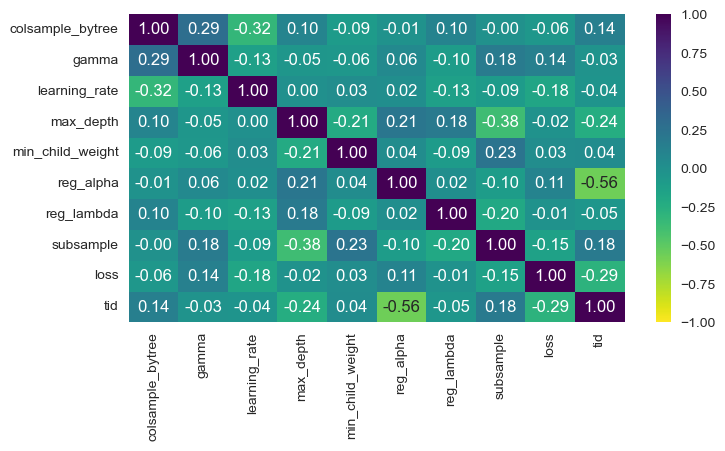

In [220]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(hyper2hr.corr(method='spearman'),
            cmap='viridis_r', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
           )

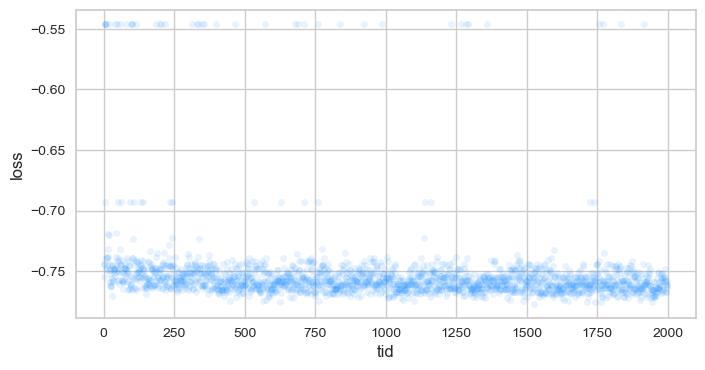

In [221]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='tid', y='loss', alpha=.1, color='dodgerblue', ax=ax)
)

plt.show()

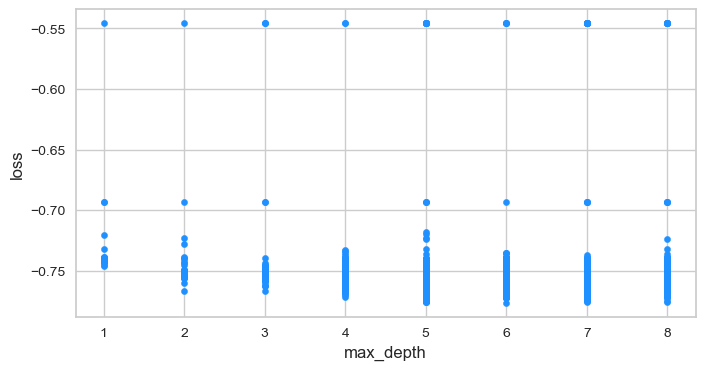

In [222]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='max_depth', y='loss', alpha=1, color='dodgerblue', ax=ax)
)

plt.show()

#### Applying Jittering 

In [223]:
# Jitter as Visualization Technique

def jitter(df: pd.DataFrame, col: str, amount: float=1) -> pd.Series:
    """
    Add random noise to the values in a Pandas DataFrame column.

    This function adds random noise to the values in a specified 
    column of a Pandas DataFrame. The noise is uniform random 
    noise with a range of `amount` centered around zero. The 
    function returns a Pandas Series with the jittered values.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    col : str
        The name of the column to jitter.
    amount : float, optional
        The range of the noise to add. The default value is 1.

    Returns
    -------
    pd.Series
        A Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount/2, high=amount/2,
                            size=df.shape[0])
    return df[col] + vals

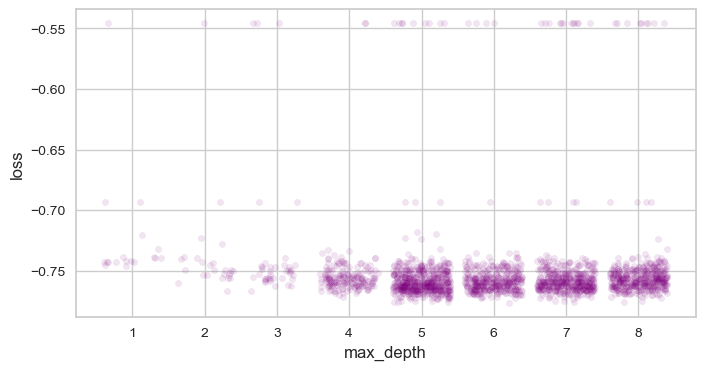

In [224]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
  .plot.scatter(x='max_depth', y='loss', alpha=.1, color='purple', ax=ax)
)

plt.show()

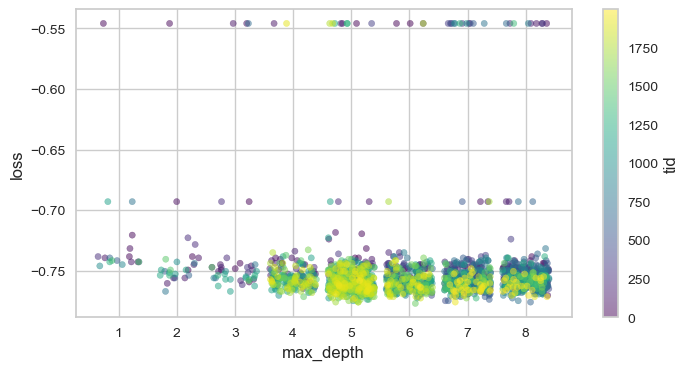

In [225]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
  .plot.scatter(x='max_depth', y='loss', alpha=.5, 
               color='tid', cmap='viridis', ax=ax)
)

plt.show()

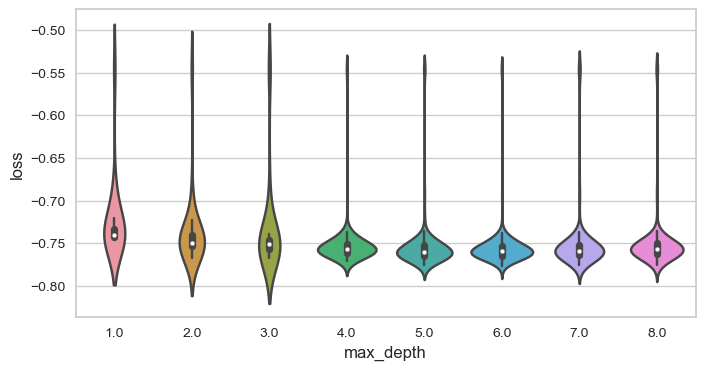

In [226]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='max_depth', y='loss', data=hyper2hr, kind='violin', ax=ax)

plt.show()

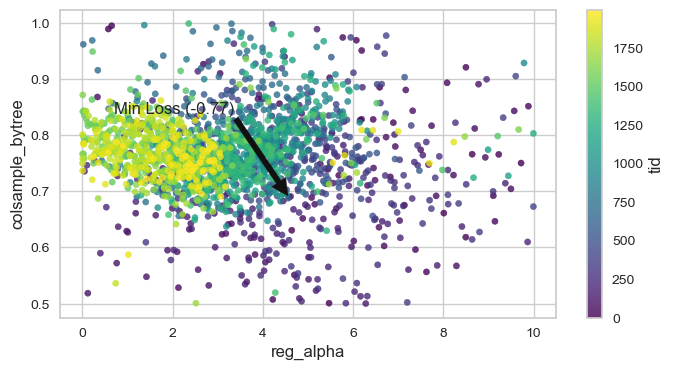

In [227]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='reg_alpha', y='colsample_bytree', alpha=.8,
               color='tid', cmap='viridis', ax=ax)
)

ax.annotate('Min Loss (-0.77)', xy=(4.56, 0.692),
           xytext=(.7, .84), arrowprops={'color':'k'})

plt.show()

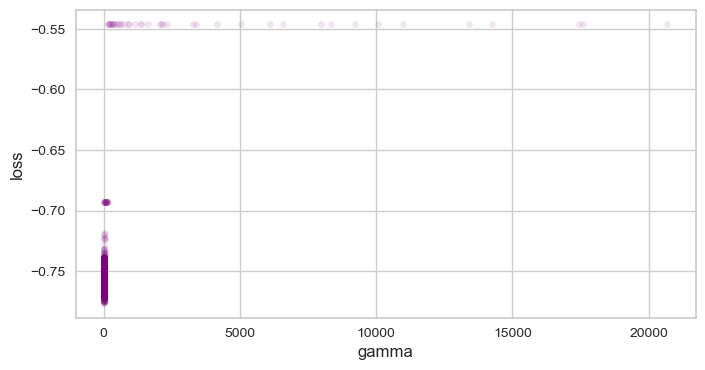

In [228]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='gamma', y='loss', alpha=.1, color='purple', ax=ax)
)

plt.show()

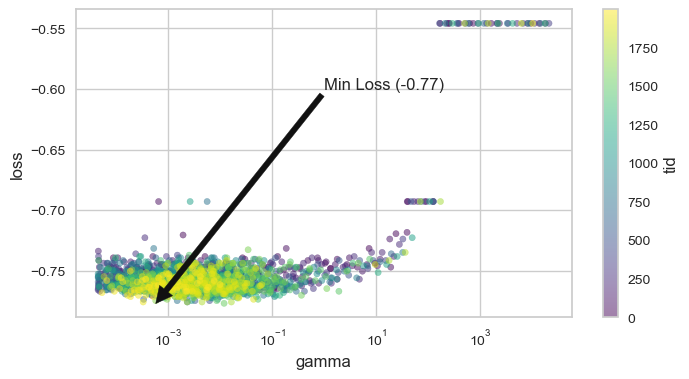

In [229]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
  .plot.scatter(x='gamma', y='loss', alpha=.5, color='tid', ax=ax, 
                logx=True, cmap='viridis')
)

ax.annotate('Min Loss (-0.77)', xy=(0.000581, -0.777),
           xytext=(1, -.6), arrowprops={'color':'k'})

plt.show()

#### E.D.A with Plotly

In [230]:
import plotly.graph_objects as go

# Helper Function
def plot_3d_mesh(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str) -> go.Figure:
    """
    Create a 3D mesh plot using Plotly.

    This function creates a 3D mesh plot using Plotly, with 
    the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The 
    plot has a title and axis labels that match the column 
    names, and the intensity of the mesh is proportional 
    to the values in the `z_col` column. The function returns 
    a Plotly Figure object that can be displayed or saved as 
    desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = go.Figure(data=[go.Mesh3d(x=df[x_col], y=df[y_col], z=df[z_col],
        intensity=df[z_col]/ df[z_col].min(),
        hovertemplate=f"{z_col}: %{{z}}<br>{x_col}: %{{x}}<br>{y_col}: "
                                    "%{{y}}<extra></extra>")],
    )

    fig.update_layout( 
        title=dict(text=f'{y_col} vs {x_col}'),
        scene = dict(
          xaxis_title=x_col,
          yaxis_title=y_col,
          zaxis_title=z_col),
        width=700,
        margin=dict(r=20, b=10, l=10, t=50)
    )
    return fig

In [231]:
fig = plot_3d_mesh(hyper2hr.query('gamma < .2'),
    'reg_lambda', 'gamma', 'loss')

fig

In [232]:
import plotly.express as px
import plotly.graph_objects as go

In [233]:
# 3-D Scatter Function

def plot_3d_scatter(df: pd.DataFrame, x_col: str, y_col: str, 
                 z_col: str, color_col: str, 
                 opacity: float=1) -> go.Figure:
    """
    Create a 3D scatter plot using Plotly Express.

    This function creates a 3D scatter plot using Plotly Express, 
    with the `x_col`, `y_col`, and `z_col` columns of the `df` 
    DataFrame as the x, y, and z values, respectively. The points 
    in the plot are colored according to the values in the 
    `color_col` column, using a continuous color scale. The 
    function returns a Plotly Express scatter_3d object that 
    can be displayed or saved as desired.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the data to plot.
    x_col : str
        The name of the column to use as the x values.
    y_col : str
        The name of the column to use as the y values.
    z_col : str
        The name of the column to use as the z values.
    color_col : str
        The name of the column to use for coloring.
    opacity : float
        The opacity (alpha) of the points.

    Returns
    -------
    go.Figure
        A Plotly Figure object with the 3D mesh plot.
    """
    fig = px.scatter_3d(data_frame=df, x=x_col,
                y=y_col, z=z_col, color=color_col,
                color_continuous_scale=px.colors.sequential.Viridis_r,
                opacity=opacity)
    return fig

In [234]:
plot_3d_scatter(hyper2hr.query('gamma < .2'), 
              'reg_lambda', 'gamma', 'tid', color_col='loss')

## Step-wise Tuning with Hyperopt

#### Groups of Hyperparameters

In [235]:
from hyperopt import fmin, tpe, hp, Trials

params = {'random_state': 42}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
          {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
          {'reg_alpha': hp.uniform('reg_alpha', 0, 10),
            'reg_lambda': hp.uniform('reg_lambda', 1, 10),},
          {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
          {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
]

In [236]:
all_trials = []

for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, 
                                        y_train, X_test, y_test),            
        space=params,           
        algo=tpe.suggest,            
        max_evals=20,            
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)

100%|████████| 20/20 [00:03<00:00,  5.43trial/s, best loss: -0.7569060773480663]


#### Visualization Hyperparameter Scores

In [237]:
plot_3d_mesh(trial2df(all_trials[2]),
    'reg_alpha', 'reg_lambda', 'loss')

#### Training an Optimized Model

In [238]:
step_params = {'random_state': 42,
 'max_depth': 5,
 'min_child_weight': 0.6411044640540848,
 'subsample': 0.9492383155577023,
 'colsample_bytree': 0.6235721099295888,
 'gamma': 0.00011273797329538491,
 'learning_rate': 0.24399020050740935}

In [239]:
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50, n_estimators=500)

In [240]:
xg_step.fit(X_train, y_train,
            eval_set=[(X_train, y_train),
                      (X_test, y_test)
                     ],
            verbose=100
           )

[0]	validation_0-logloss:0.64342	validation_1-logloss:0.64282
[85]	validation_0-logloss:0.36150	validation_1-logloss:0.51357


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6235721099295888, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00011273797329538491, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24399020050740935, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.6411044640540848, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [241]:
xg_step.score(X_test, y_test)

0.7613259668508288

In [242]:
xg_def = xgb.XGBClassifier()

In [243]:
xg_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [244]:
xg_def.score(X_test, y_test)

0.7458563535911602

## Do you have enough data?

#### Learning Curves

In [245]:
params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/isisromero/opt/anaconda3/envs/Data-science-from-scratch/lib/python3.9/site-packages/scipy/

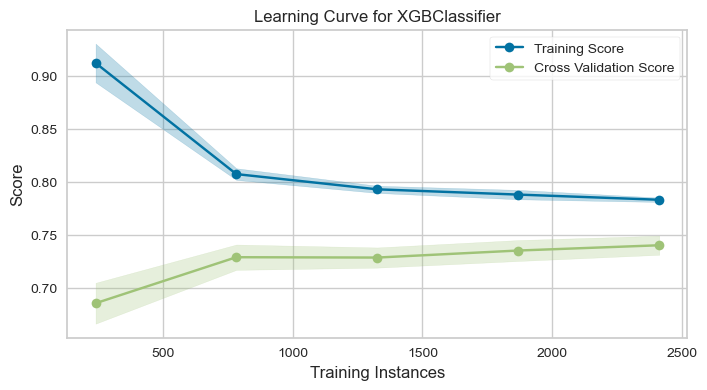

(0.6, 1.0)

In [246]:
import yellowbrick.model_selection as ms

fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(xgb.XGBClassifier(**params),
                        X, y, ax=ax
                       )
ax.set_ylim(0.6, 1)

#### Learning Curves for Decision Trees

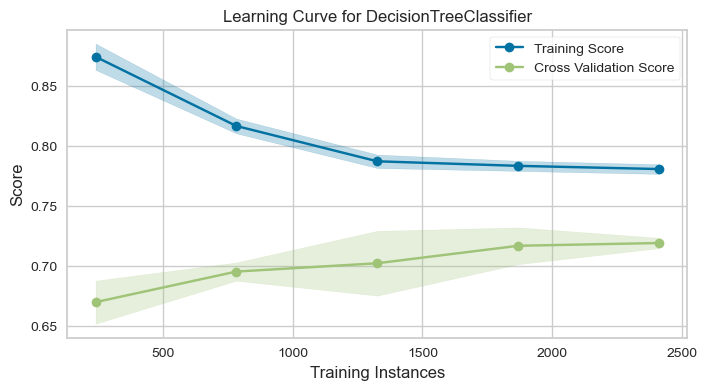

(0.6, 1.0)

In [247]:
# Tuned tree
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=7),
                        X, y, ax=ax)
viz.ax.set_ylim(0.6, 1)

#### Underfit Learning Curves

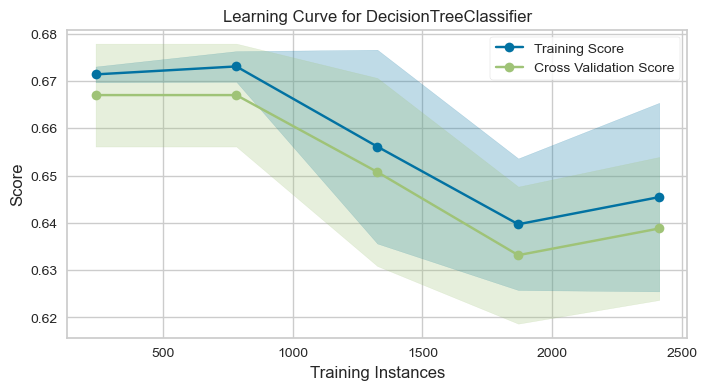

(0.6, 1.0)

In [248]:
# Underfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=1),
                        X, y, ax=ax
                       )
ax.set_ylim(0.6, 1)

#### Overfit Learning Curves

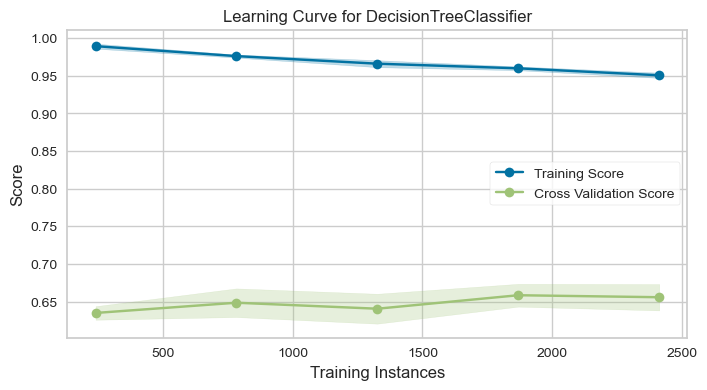

(0.6, 1.0)

In [249]:
# Overfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(),
                        X, y, ax=ax
                       )
ax.set_ylim(0.6, 1)

## Model Evaluation

#### Accuracy

In [250]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [251]:
xgb_def.score(X_test, y_test)

0.7458563535911602

In [252]:
from sklearn import metrics

In [253]:
metrics.accuracy_score(y_test, xgb_def.predict(X_test))

0.7458563535911602

#### Confusion Matrix

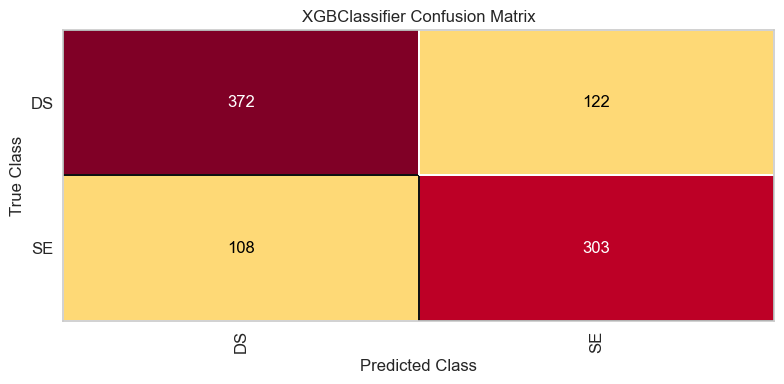

ConfusionMatrix(ax=<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['DS', 'SE'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7feedc3fd790>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_r...
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

In [254]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.confusion_matrix(xgb_def, X_train, y_train,
                            X_test, y_test,
                            classes=['DS', 'SE'], ax=ax
                           )

In [255]:
# Through NumPy
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test))

In [256]:
cm

array([[372, 122],
       [108, 303]])

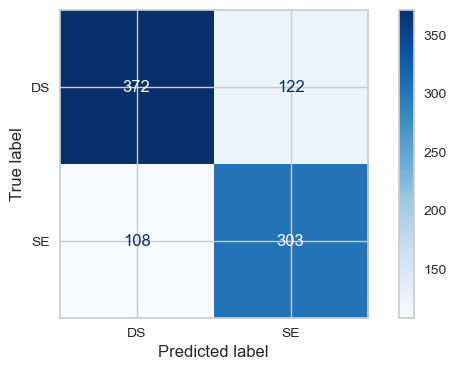

In [257]:
fig, ax = plt.subplots(figsize=(8, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=['DS', 'SE'])
disp.plot(ax=ax, cmap='Blues')

plt.show()

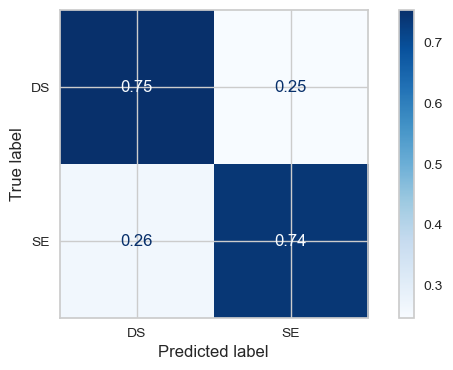

In [258]:
fig, ax = plt.subplots(figsize=(8, 4))
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test),
                              normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DS', 'SE'])
disp.plot(ax=ax, cmap='Blues')

plt.show()

#### Precision & Recall

In [259]:
metrics.precision_score(y_test, xgb_def.predict(X_test))

0.7129411764705882

In [260]:
metrics.recall_score(y_test, xgb_def.predict(X_test))

0.7372262773722628

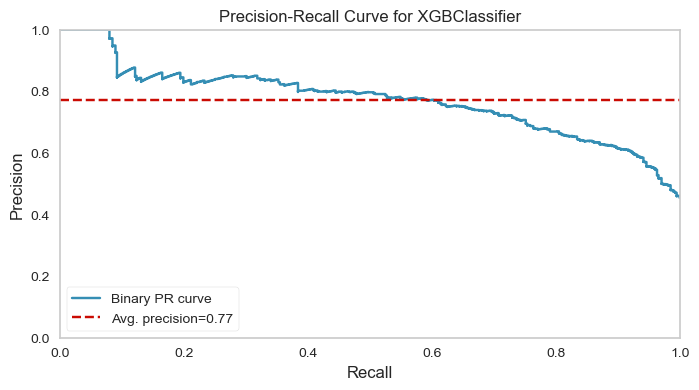

(0.0, 1.05)

In [261]:
# Precision-Recall Curve
from yellowbrick import classifier

fig, ax = plt.subplots(figsize=(8, 4))
classifier.precision_recall_curve(xgb_def, X_train, y_train,
                                  X_test, y_test, micro=False, macro=False, ax=ax, per_class=True)
ax.set_ylim(0, 1.05)

#### F1 Score

In [262]:
metrics.f1_score(y_test, xgb_def.predict(X_test))

0.7248803827751197

In [263]:
print(metrics.classification_report(y_test,
                                    y_pred=xgb_def.predict(X_test), target_names=['DS', 'SE']))

              precision    recall  f1-score   support

          DS       0.78      0.75      0.76       494
          SE       0.71      0.74      0.72       411

    accuracy                           0.75       905
   macro avg       0.74      0.75      0.74       905
weighted avg       0.75      0.75      0.75       905



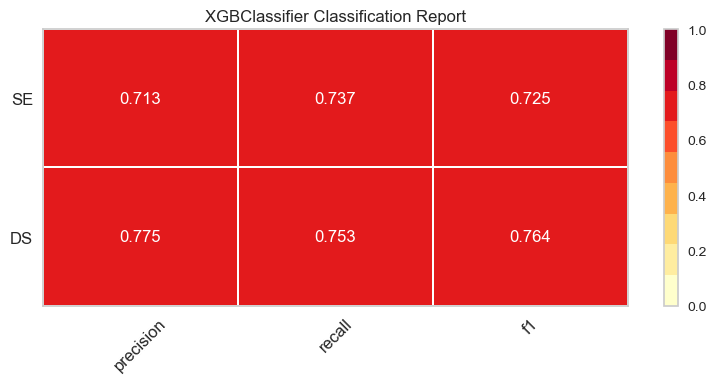

ClassificationReport(ax=<Axes: title={'center': 'XGBClassifier Classification Report'}>,
                     classes=['DS', 'SE'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x7fef143a1dc0>,
                     estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=Fal...
                                             gpu_id=None, grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=100, n_jobs=None,
                                             num_parallel_tree=None,
                                             predictor=None, random_state=None, ...))

In [264]:
# Class-Report Visualization
fig, ax = plt.subplots(figsize=(8, 4))
classifier.classification_report(xgb_def, X_train, y_train, X_test, y_test, classes=['DS', 'SE'],
                                 micro=False, macro=False, ax=ax)

#### ROC Curve

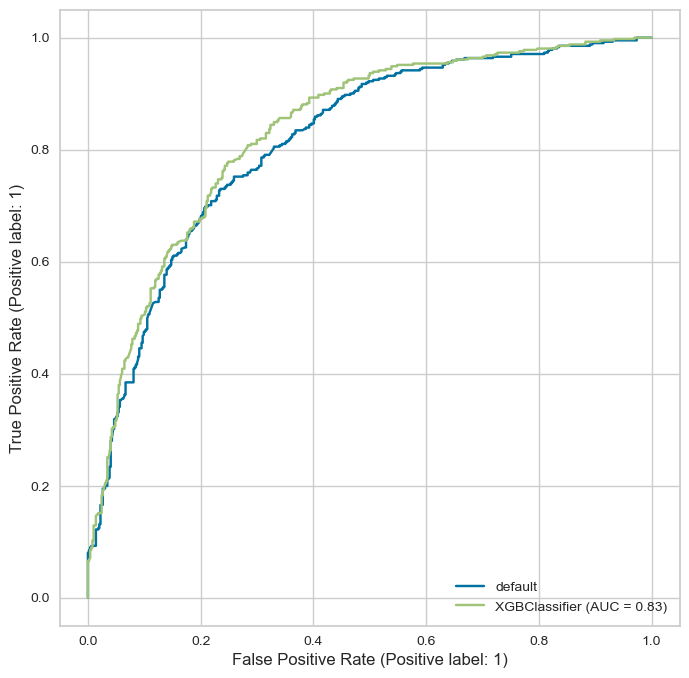

In [265]:
fig, ax = plt.subplots(figsize=(8, 8))
metrics.RocCurveDisplay.from_estimator(xgb_def,
                                       X_test, y_test, ax=ax, label='default')
metrics.RocCurveDisplay.from_estimator(xg_step,
                                       X_test, y_test, ax=ax)

plt.show()

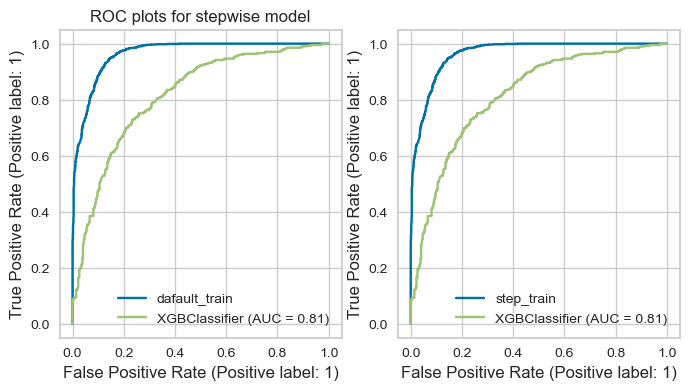

In [267]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
metrics.RocCurveDisplay.from_estimator(xgb_def,
                                       X_train, y_train, ax=axes[0], label='dafault_train')
metrics.RocCurveDisplay.from_estimator(xgb_def,
                                       X_test, y_test, ax=axes[0])
axes[0].set(title='ROC plots for default model')

metrics.RocCurveDisplay.from_estimator(xgb_def,
                                       X_train, y_train, ax=axes[1], label='step_train')
metrics.RocCurveDisplay.from_estimator(xgb_def,
                                       X_test, y_test, ax=axes[1])
axes[0].set(title='ROC plots for stepwise model')

plt.show()

#### Threshold Metrics

In [268]:
class ThresholdXGBClassifier(xgb.XGBClassifier):
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def predict(self, X, *args, **kwargs):
        """Predict with `threshold` applied to predicted class probabilities.
        """
        proba = self.predict_proba(X, *args, **kwargs)
        return (proba[:, 1] > self.threshold).astype(int)

In [269]:
xgb_def = xgb.XGBClassifier()

In [270]:
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [271]:
xgb_def.predict(X_test.iloc[[0]])

array([1])

In [272]:
# Threshold at .9
xgb90 = ThresholdXGBClassifier(threshold=.9, verbosity=0)
xgb90.fit(X_train, y_train)

ThresholdXGBClassifier(base_score=None, booster=None, callbacks=None,
                       colsample_bylevel=None, colsample_bynode=None,
                       colsample_bytree=None, early_stopping_rounds=None,
                       enable_categorical=False, eval_metric=None,
                       feature_types=None, gamma=None, gpu_id=None,
                       grow_policy=None, importance_type=None,
                       interaction_constraints=None, learning_rate=None,
                       max_bin=None, max_cat_threshold=None,
                       max_cat_to_onehot=None, max_delta_step=None,
                       max_depth=None, max_leaves=None, min_child_weight=None,
                       missing=nan, monotone_constraints=None, n_estimators=100,
                       n_jobs=None, num_parallel_tree=None,
                       objective='binary:logistic', predictor=None, ...)

In [273]:
xgb90.predict(X_test.iloc[[0]])

array([0])

In [274]:
def get_tpr_fpr(probs, y_truth):
    """
    Calculates true positive rate (TPR) and false positive rate
    (FPR) given predicted probabilities and ground truth labels.

    Parameters:
    probs (np.array): predicted probabilities of positive class
    y_truth (np.array): ground truth labels

    Returns:
    tuple: (tpr, fpr)
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr

In [275]:
vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = xg_step.predict_proba(X_test)[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_test)
    val = [thresh, tpr, fpr]
    for metric in [metrics.accuracy_score, metrics.precision_score,
                   metrics.recall_score, metrics.f1_score, 
                   metrics.roc_auc_score]:
        val.append(metric(y_test, probs > thresh))
    vals.append(val)

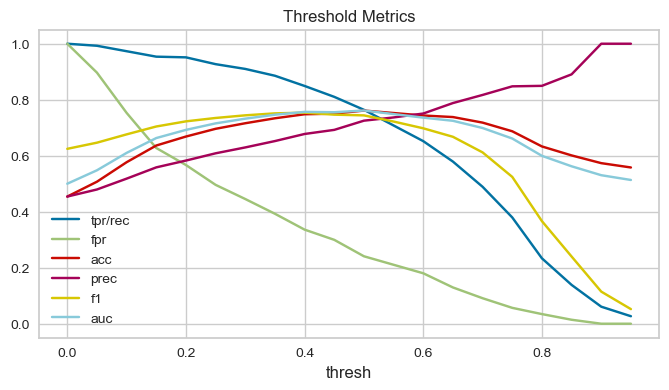

In [277]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 'fpr', 'acc', 
                             'prec', 'rec', 'f1', 'auc'])
 .drop(columns='rec')
 .set_index('thresh')
 .plot(ax=ax, title='Threshold Metrics')
)

plt.show()

#### Cumulative Gains Curve

In [278]:
import scikitplot

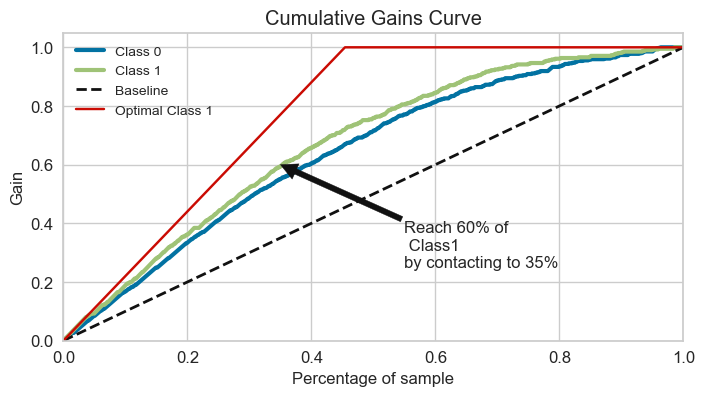

In [281]:
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)
ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')
ax.set_ylim(0, 1.05)
ax.annotate('Reach 60% of\n Class1\nby contacting to 35%', xy=(.35, .6),
            xytext=(.55, .25), arrowprops={'color':'k'})
ax.legend()
plt.show()

#### Lift Curves

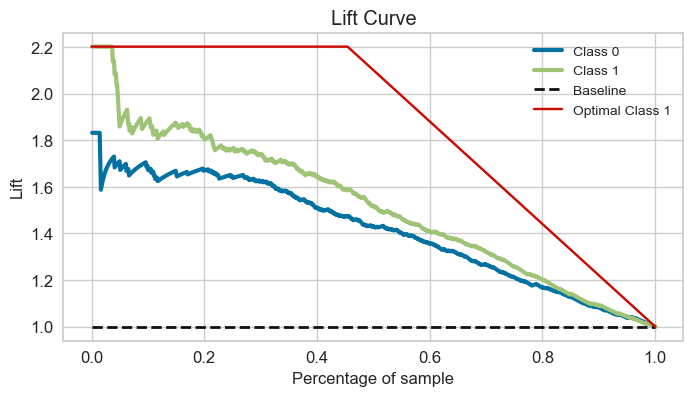

In [283]:
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_lift_curve(y_test, y_probs, ax=ax)
mean = (y_test == 1).mean()
ax.plot([0, mean, 1], [1/mean, 1/mean, 1], label='Optimal Class 1')
ax.legend()

plt.show()